## Imports and definitions

In [1]:
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from saphyra import TunedDataReader
import mplhep as hep
from ringer.plotting import set_defaults
plt.style.use(hep.style.ATLAS)
set_defaults()

Module libc not found.


Welcome to JupyROOT 6.26/10
Using all sub packages with ROOT dependence


2023-02-09 16:14:30.382162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 16:14:32.498449: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-09 16:14:42.621572: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: UNKNOWN ERROR (34)
2023-02-09 16:14:42.621649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (caloba16): /proc/driver/nvidia/version does not e

In [8]:
def get_history_df(fit_results_df):
    history_df = pd.DataFrame.from_dict(fit_results_df["history"].to_list())
    history_df["best_epoch"] = history_df["max_sp_best_epoch_val"].apply(lambda x: max(x))
    history_df["n_epochs"] = history_df["loss"].apply(lambda x: len(x))
    history_df["imodel"] = fit_results_df["imodel"]
    history_df["sort"] = fit_results_df["sort"]
    history_df["init"] = fit_results_df["init"]
    current_cols = history_df.columns
    new_col_order = ["imodel", "sort", "init", "n_epochs", "best_epoch"]
    new_col_order += current_cols[~current_cols.isin(new_col_order)].to_list()
    history_df = history_df[new_col_order]
    return history_df

In [3]:
def get_metric_df_from_history_df(history_df, metric_name, sort):
    sort_hist_df = history_df[history_df["sort"] == sort].sort_values(by="init")
    for i, metric2plot in enumerate(metrics_to_plot):
        cols = [
            pd.Series(row[metric2plot], name=f"init {row['init']}")
            for idx, row in sort_hist_df.iterrows()
        ]
        if len(cols) == 0:
            raise ValueError(str(cols))
        metric_df = pd.concat(cols, axis=1)
    return metric_df

In [20]:
def plot_fold_metric(history_df,
                     metric_name,
                     sort,
                     include_val,
                     include_shadows=False,
                     include_errorbars=True,
                     ax=None):
    metrics_to_plot = [metric_name]
    if include_val:
        metrics_to_plot += [f"val_{metric_name}"]
    if ax is None:
        ax = plt.gca()
    sort_hist_df = history_df[history_df["sort"] == sort].sort_values(by="init")
    for i, metric2plot in enumerate(metrics_to_plot):
        plot_df = get_metric_df_from_history_df(history_df, metric2plot, sort)
        if include_shadows:
            for col_name, col in plot_df.items():
                ax.plot(np.arange(1, len(col)+1),
                        col,
                        alpha=0.3,
                        color=f"C{i}")
        ax.errorbar(x=np.arange(1, len(plot_df)+1),
                    y=plot_df.mean(axis=1),
                    yerr=plot_df.std(axis=1) if include_errorbars else None,
                    color=f"C{i}",
                    label="val" if i else "train")
    for i, row in sort_hist_df.iterrows():
        ax.axvline(row["best_epoch"], color="red", linestyle="--", alpha=.2)
    return ax

## Args


In [5]:
dir_path = "/home/lucas.nunes/workspace/ringer_tunings/versions/vInception/v2/jobs_dev01/output/user.lbarranunes.data17_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM1.bkg.VProbes_EGAM7.GRL_v97_et4_eta0.rp.r1"
dir_src, dir_name = os.path.split(dir_path)
output_dir = os.path.join(dir_src, f"fit_analysis_{dir_name}")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Loading DataFrames

In [6]:
loaded_data = TunedDataReader().load(dir_path)
model_histories = loaded_data.get_data()
fit_results_df = pd.DataFrame.from_dict(model_histories)
fit_results_df

,imodel,sort,init,history,sequence,weights,metadata,time
0,0,3,4,"{'loss': [5.438414573669434, 0.059983652085065...","{'class_name': 'Functional', 'config': {'name'...","[[[[-0.17925072 0.4683006 ]], [[ 0.13788019 -...",{},0 days 00:37:40.121425
1,0,6,8,"{'loss': [1.2646697759628296, 0.06240025535225...","{'class_name': 'Functional', 'config': {'name'...","[[[[-0.03352463 -0.02386262]], [[-0.01102663 -...",{},0 days 02:03:38.816282
2,0,7,2,"{'loss': [2.450721263885498, 0.178208380937576...","{'class_name': 'Functional', 'config': {'name'...","[[[[-0.01862479 -0.11378231]], [[-0.00995904 ...",{},0 days 01:42:16.466129
3,0,4,5,"{'loss': [1.4041754007339478, 0.29836314916610...","{'class_name': 'Functional', 'config': {'name'...","[[[[-0.14552219 0.09447755]], [[ 0.00540315 -...",{},0 days 01:47:34.691870
4,0,0,1,"{'loss': [0.9320138096809387, 0.02466871589422...","{'class_name': 'Functional', 'config': {'name'...","[[[[0.06198116 0.6718508 ]], [[-0.40297422 -0....",{},0 days 00:31:38.409142
...,...,...,...,...,...,...,...,...
95,0,0,2,"{'loss': [1.0407917499542236, 0.41389900445938...","{'class_name': 'Functional', 'config': {'name'...","[[[[-0.04380971 -0.02625201]], [[-0.05102915 ...",{},0 days 00:47:31.915039
96,0,1,7,"{'loss': [1.0102965831756592, 0.02262936532497...","{'class_name': 'Functional', 'config': {'name'...","[[[[-0.26747844 -0.01898658]], [[0.00924924 0....",{},0 days 01:08:37.587610
97,0,5,1,"{'loss': [2.8108229637145996, 0.28726759552955...","{'class_name': 'Functional', 'config': {'name'...","[[[[-0.19638498 0.23112622]], [[-0.34406772 -...",{},0 days 01:07:07.685002
98,0,0,3,"{'loss': [2.485680341720581, 0.532182931900024...","{'class_name': 'Functional', 'config': {'name'...","[[[[-0.02832337 0.03636339]], [[-6.1950501e-0...",{},0 days 01:04:04.271185


2023-02-09 16:14:48,906 | Py.TunedDataReader                      INFO Reading tuned data collection...|------------------------------------------------------------| 0/100
2023-02-09 16:14:49,024 | Py.TunedDataReader                      INFO Reading tuned data collection...|------------------------------------------------------------| 1/100
2023-02-09 16:14:49,215 | Py.TunedDataReader                      INFO Reading tuned data collection...|#-----------------------------------------------------------| 2/100
2023-02-09 16:14:49,365 | Py.TunedDataReader                      INFO Reading tuned data collection...|#-----------------------------------------------------------| 3/100
2023-02-09 16:14:49,535 | Py.TunedDataReader                      INFO Reading tuned data collection...|##----------------------------------------------------------| 4/100
2023-02-09 16:14:49,704 | Py.TunedDataReader                      INFO Reading tuned data collection...|###---------------------------------

In [9]:
history_df = get_history_df(fit_results_df)
history_df

,imodel,sort,init,n_epochs,best_epoch,loss,accuracy,val_loss,val_accuracy,max_sp_val,max_sp_fa_val,max_sp_pd_val,max_sp_partial_derivative_fa_val,max_sp_partial_derivative_pd_val,max_sp_best_epoch_val,summary,reference
0,0,3,4,49,22,"[5.438414573669434, 0.05998365208506584, 0.011...","[0.9727335572242737, 0.9920098185539246, 0.997...","[0.10975999385118484, 0.01375278364866972, 0.0...","[0.9956849217414856, 0.9969776272773743, 0.997...","[0.9963910198002076, 0.9973411407269818, 0.997...","[0.005592016256107978, 0.003687335197338752, 0...","[0.9983760311613731, 0.9983701472163056, 0.998...","[-0.5004977461564271, -0.5002574514090363, -0....","[0.49950214030958623, 0.49974170981593197, 0.4...","[0, 1, 2, 4, 5, 7, 8, 9, 11, 22]",{'rocs': {'roc': ([0. 0.67035742 0.670...,{'tight_cutbased': {'pd_ref': [0.9962596734150...
1,0,6,8,97,70,"[1.2646697759628296, 0.06240025535225868, 0.02...","[0.9884886741638184, 0.9950240254402161, 0.996...","[0.09179850667715073, 0.026667702943086624, 0....","[0.990153968334198, 0.9972939491271973, 0.9968...","[0.9915934579698176, 0.9975776810007727, 0.997...","[0.01652668940965498, 0.0029498681578710014, 0...","[0.999746990362098, 0.9981053696882686, 0.9977...","[-0.5020593873249254, -0.500131707478942, -0.5...","[0.49795634248095494, 0.4998672576902085, 0.49...","[0, 1, 3, 4, 5, 6, 8, 9, 10, 12, 13, 18, 23, 2...",{'rocs': {'roc': ([0.00000000e+00 4.57639873e-...,{'tight_cutbased': {'pd_ref': [0.9962596734150...
2,0,7,2,80,53,"[2.450721263885498, 0.1782083809375763, 0.0550...","[0.9933896660804749, 0.9954222440719604, 0.995...","[0.2565700113773346, 0.08435890823602676, 0.02...","[0.9960012435913086, 0.9963705539703369, 0.995...","[0.9965746042413408, 0.996845705211394, 0.9967...","[0.005260435318928813, 0.004889048054859205, 0...","[0.998411334831778, 0.9985819692387352, 0.9975...","[-0.5004604209321076, -0.5004350767507518, -0....","[0.49953932272504675, 0.49956457625572576, 0.4...","[0, 1, 3, 4, 5, 6, 7, 8, 10, 12, 15, 16, 23, 3...",{'rocs': {'roc': ([0.00000000e+00 2.94197061e-...,{'tight_cutbased': {'pd_ref': [0.9962596734150...
3,0,4,5,85,58,"[1.4041754007339478, 0.2983631491661072, 0.172...","[0.9950271248817444, 0.9967228770256042, 0.996...","[0.31375226378440857, 0.2035546600818634, 0.08...","[0.997771143913269, 0.9970672130584717, 0.9973...","[0.9979408789067937, 0.9978560655678661, 0.997...","[0.003058631282396821, 0.0028225357194017497, ...","[0.998940889887852, 0.9985348976781953, 0.9985...","[-0.5002500287881422, -0.5001695490361919, -0....","[0.4997491173596896, 0.49982946185859384, 0.49...","[0, 4, 5, 7, 8, 9, 11, 12, 14, 15, 17, 18, 20,...",{'rocs': {'roc': ([0. 0.00644945 0.014...,{'tight_cutbased': {'pd_ref': [0.9962596734150...
4,0,0,1,42,15,"[0.9320138096809387, 0.02466871589422226, 0.01...","[0.9776235818862915, 0.9971318244934082, 0.997...","[0.0694771260023117, 0.017597049474716187, 0.0...","[0.9959774613380432, 0.9971238970756531, 0.997...","[0.9949236861161646, 0.9976397084525958, 0.997...","[0.0014377992651837704, 0.0030904725902935284,...","[0.9912918125386132, 0.9983701568062134, 0.997...","[-0.4990876758609077, -0.5001825250832932, -0....","[0.5009145568556301, 0.49981650412356066, 0.49...","[0, 1, 3, 4, 7, 10, 12, 13, 15]",{'rocs': {'roc': ([0.00000000e+00 5.35439001e-...,{'tight_cutbased': {'pd_ref': [0.9962596734150...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,2,62,35,"[1.0407917499542236, 0.4138990044593811, 0.135...","[0.995296061038971, 0.9962040185928345, 0.9960...","[0.8938190340995789, 0.162644162774086, 0.0713...","[0.9967710375785828, 0.997021496295929, 0.9966...","[0.9971701728995759, 0.9973390031685484, 0.997...","[0.004252384173597018, 0.0038385526507765974, ...","[0.998593745403195, 0.9985172545673855, 0.9985...","[-0.5003564779758095, -0.5002948834486335, -0....","[0.49964292641558317, 0.4997043605043069, 0.49...","[0, 1, 4, 5, 9, 10, 12, 13, 14, 18, 19, 21, 23...",{'rocs': {'roc': ([0.00000000e+00 1.73903265e-...,{'tig

## Plotting metric development by epoch per fold with multiple inits

In [21]:
metrics_to_plot = {
    # "loss": {
    #     "main_ax": {
    #         "plot_kwargs": dict(include_shadows=True, include_val=True, include_errorbars=False),
    #         "set_kwargs": dict(xlim=(1,10)),
    #         "legend_kwargs": dict()
    #     },
    #     "sub_ax": {
    #         "add_axes_kwargs": dict(rect=[0.33, 0.38, 0.6, 0.4]),
    #         "plot_kwargs": dict(include_shadows=True, include_val=True),
    #         "set_kwargs": dict(),
    #     }
    # },
    # "accuracy": {
    #     "main_ax": {
    #         "plot_kwargs": dict(include_shadows=True, include_val=True, include_errorbars=False),
    #         "set_kwargs": dict(xlim=(1,20)),
    #         "legend_kwargs": dict(loc=4)
    #     },
    #     "sub_ax": {
    #         "add_axes_kwargs": dict(rect=[0.3, 0.3, 0.6, 0.4]),
    #         "plot_kwargs": dict(include_shadows=True, include_val=True, include_errorbars=False),
    #         "set_kwargs": dict()
    #     }
    # },
    "max_sp_val": {
        "main_ax": {
            "plot_kwargs": dict(include_shadows=True, include_val=False, include_errorbars=False),
            "set_kwargs": dict(),
            "legend_kwargs": None
        },
        "sub_ax": None
    },
    # "max_sp_fa_val": {
    #     "main_ax": {
    #         "plot_kwargs": dict(include_shadows=True, include_val=False, include_errorbars=False),
    #         "set_kwargs": dict(),
    #         "legend_kwargs": None
    #     },
    #     "sub_ax": None
    # },
    # "max_sp_pd_val": {
    #     "main_ax": {
    #         "plot_kwargs": dict(include_shadows=True, include_val=False, include_errorbars=False),
    #         "set_kwargs": dict(),
    #         "legend_kwargs": None
    #     },
    #     "sub_ax": None
    # }
}


Plotting max_sp_val sort 0
Plotting max_sp_val sort 1
Plotting max_sp_val sort 2
Plotting max_sp_val sort 3
Plotting max_sp_val sort 4
Plotting max_sp_val sort 5
Plotting max_sp_val sort 6
Plotting max_sp_val sort 7
Plotting max_sp_val sort 8
Plotting max_sp_val sort 9


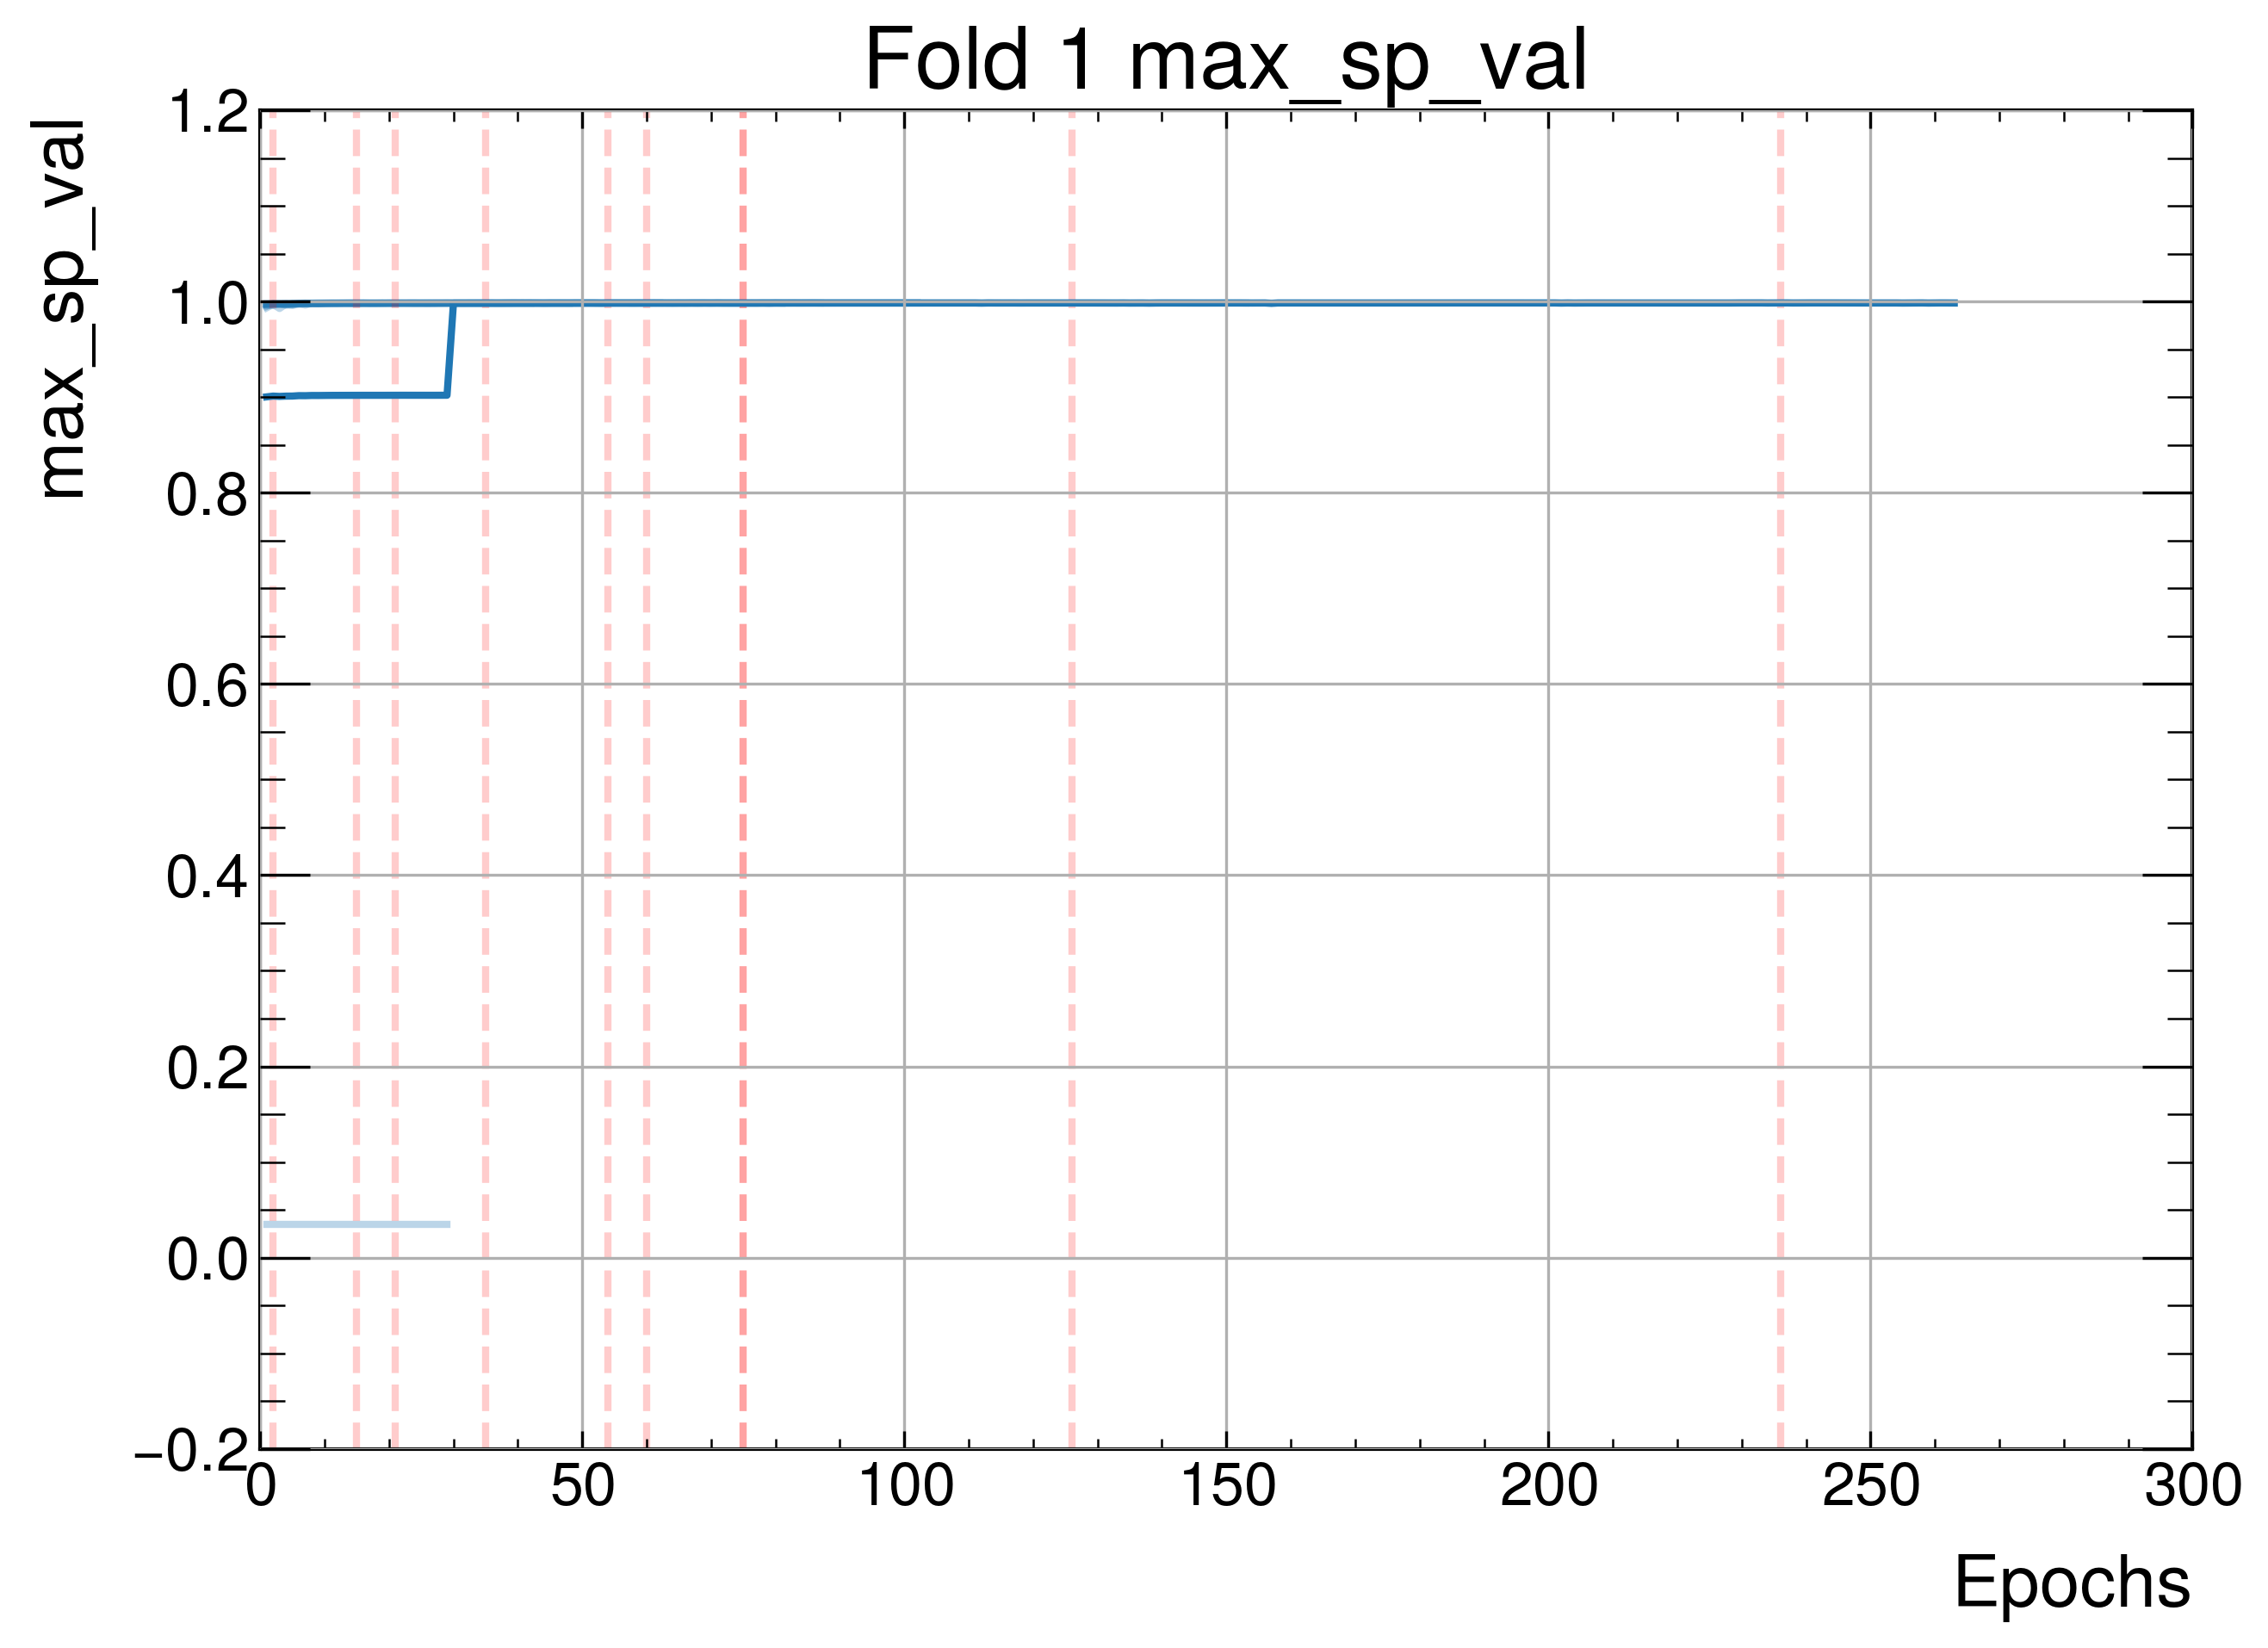

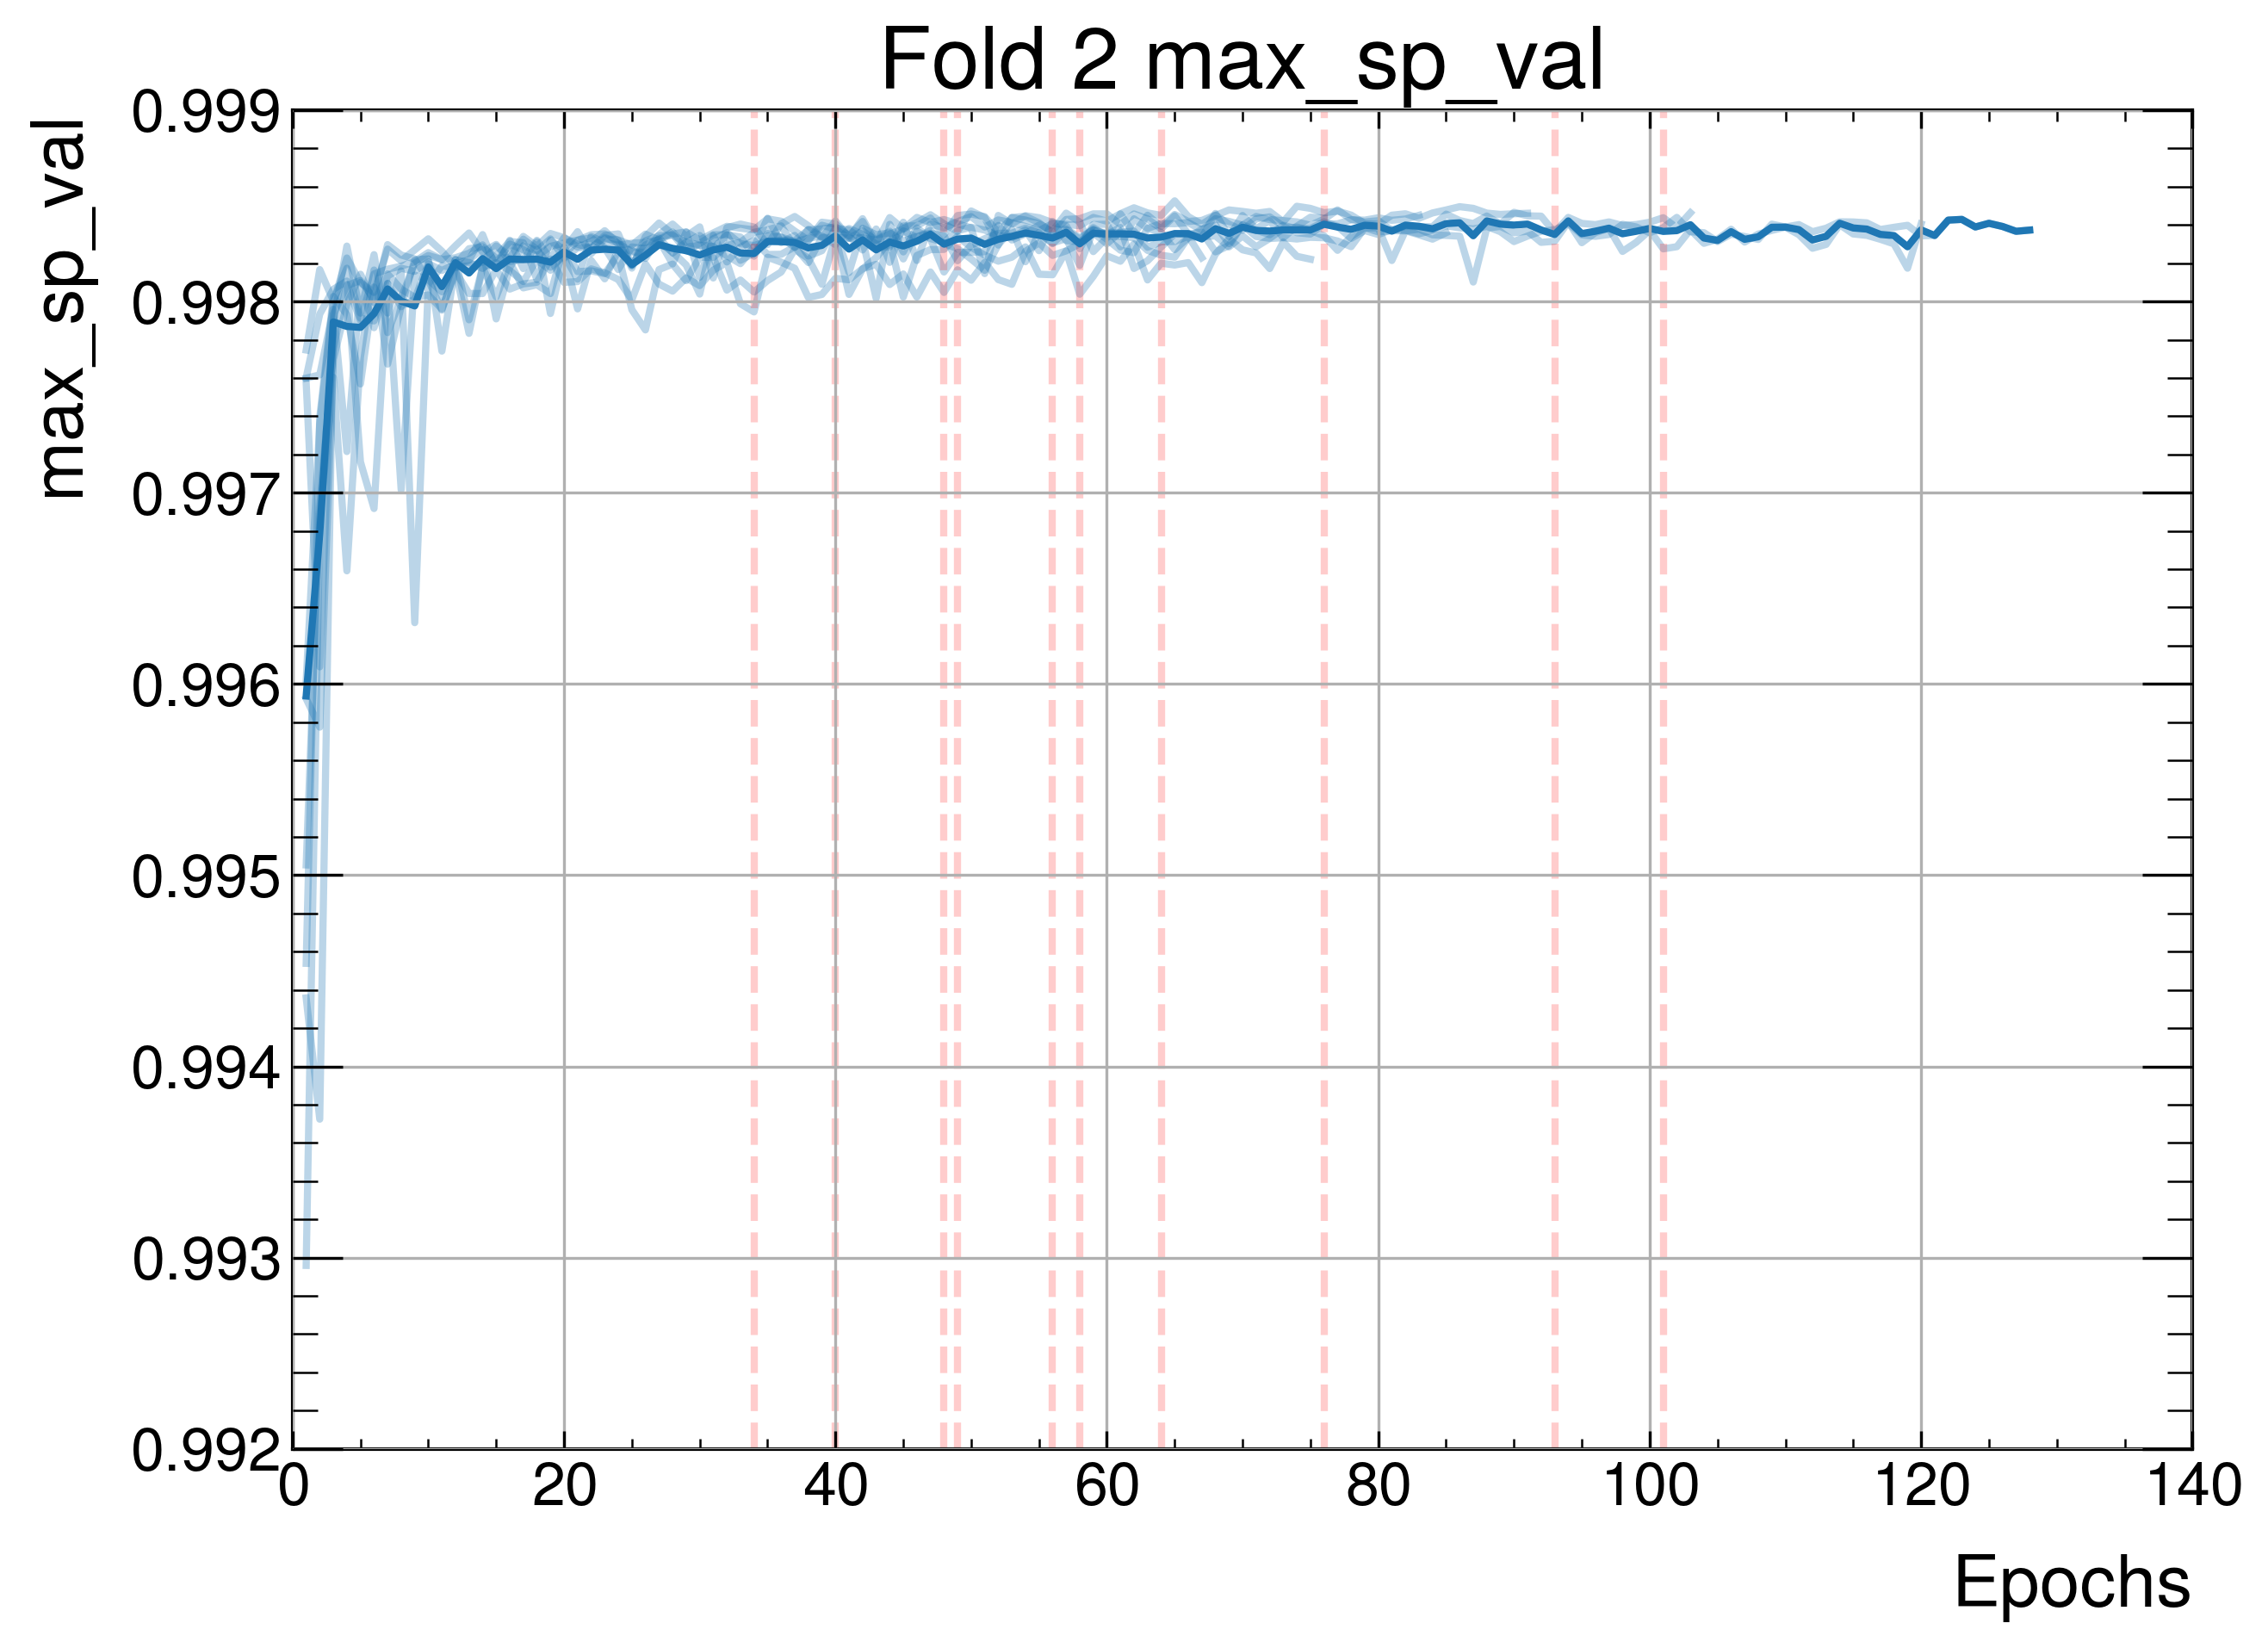

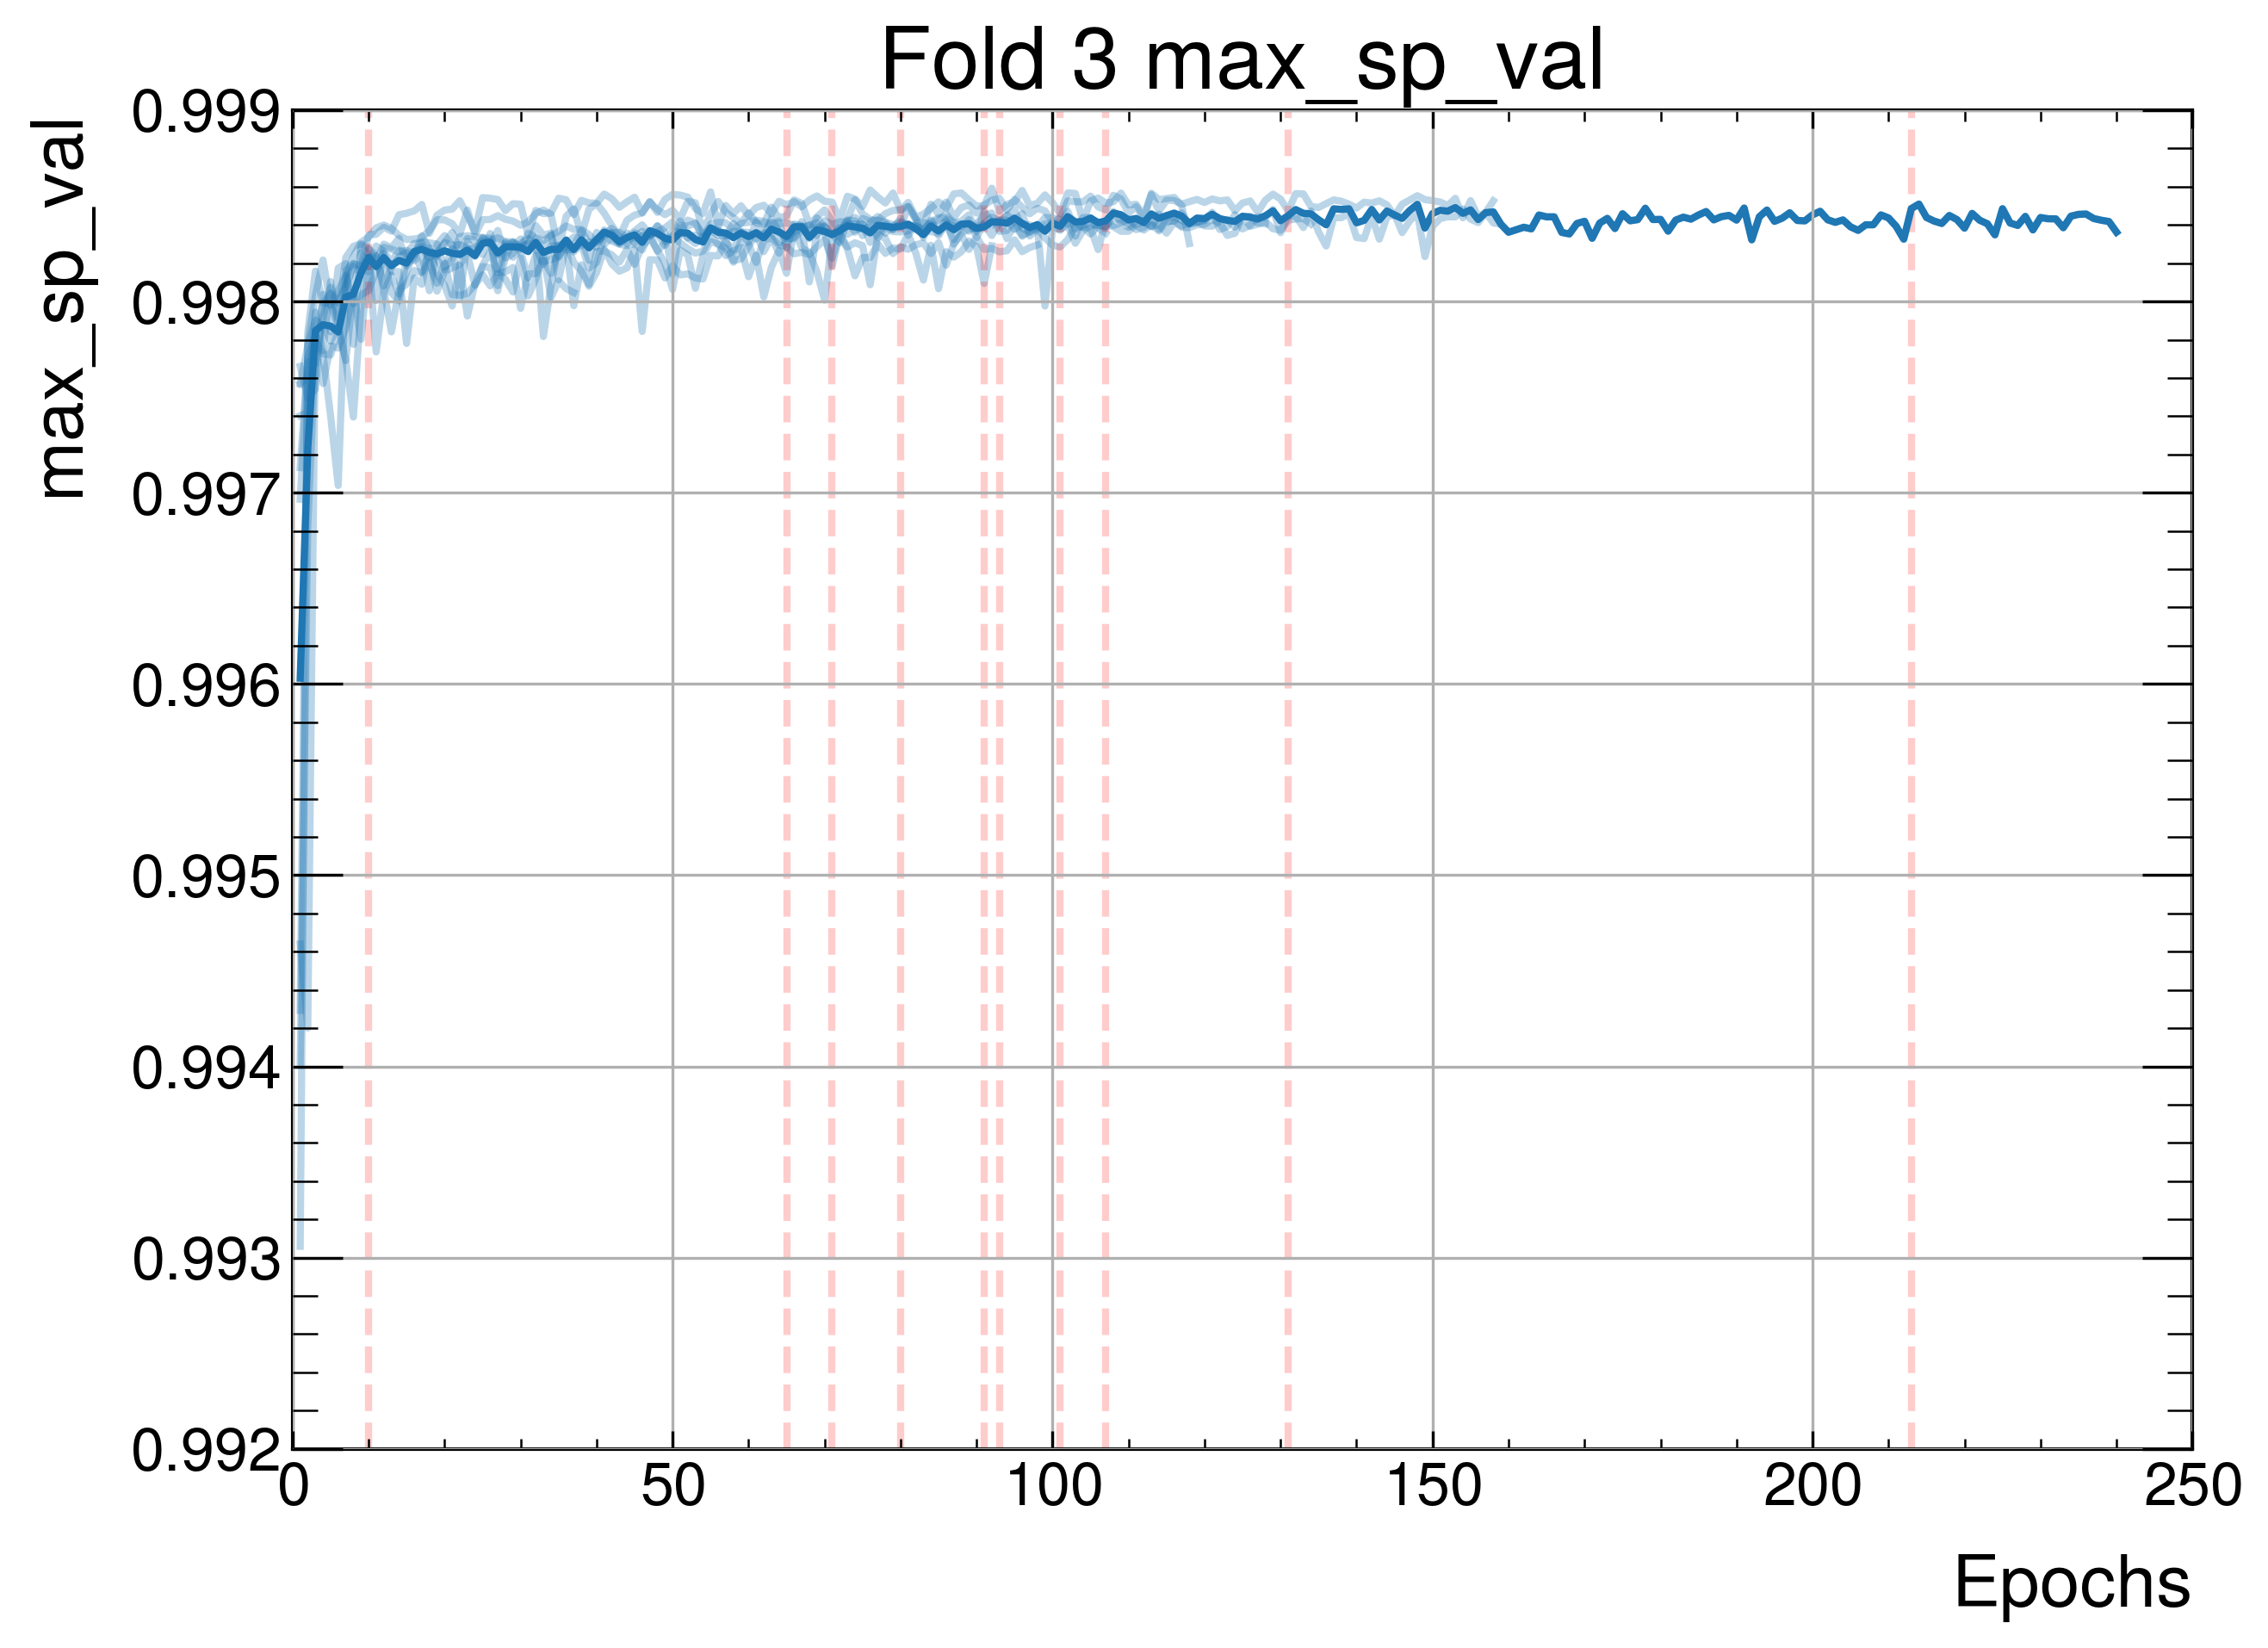

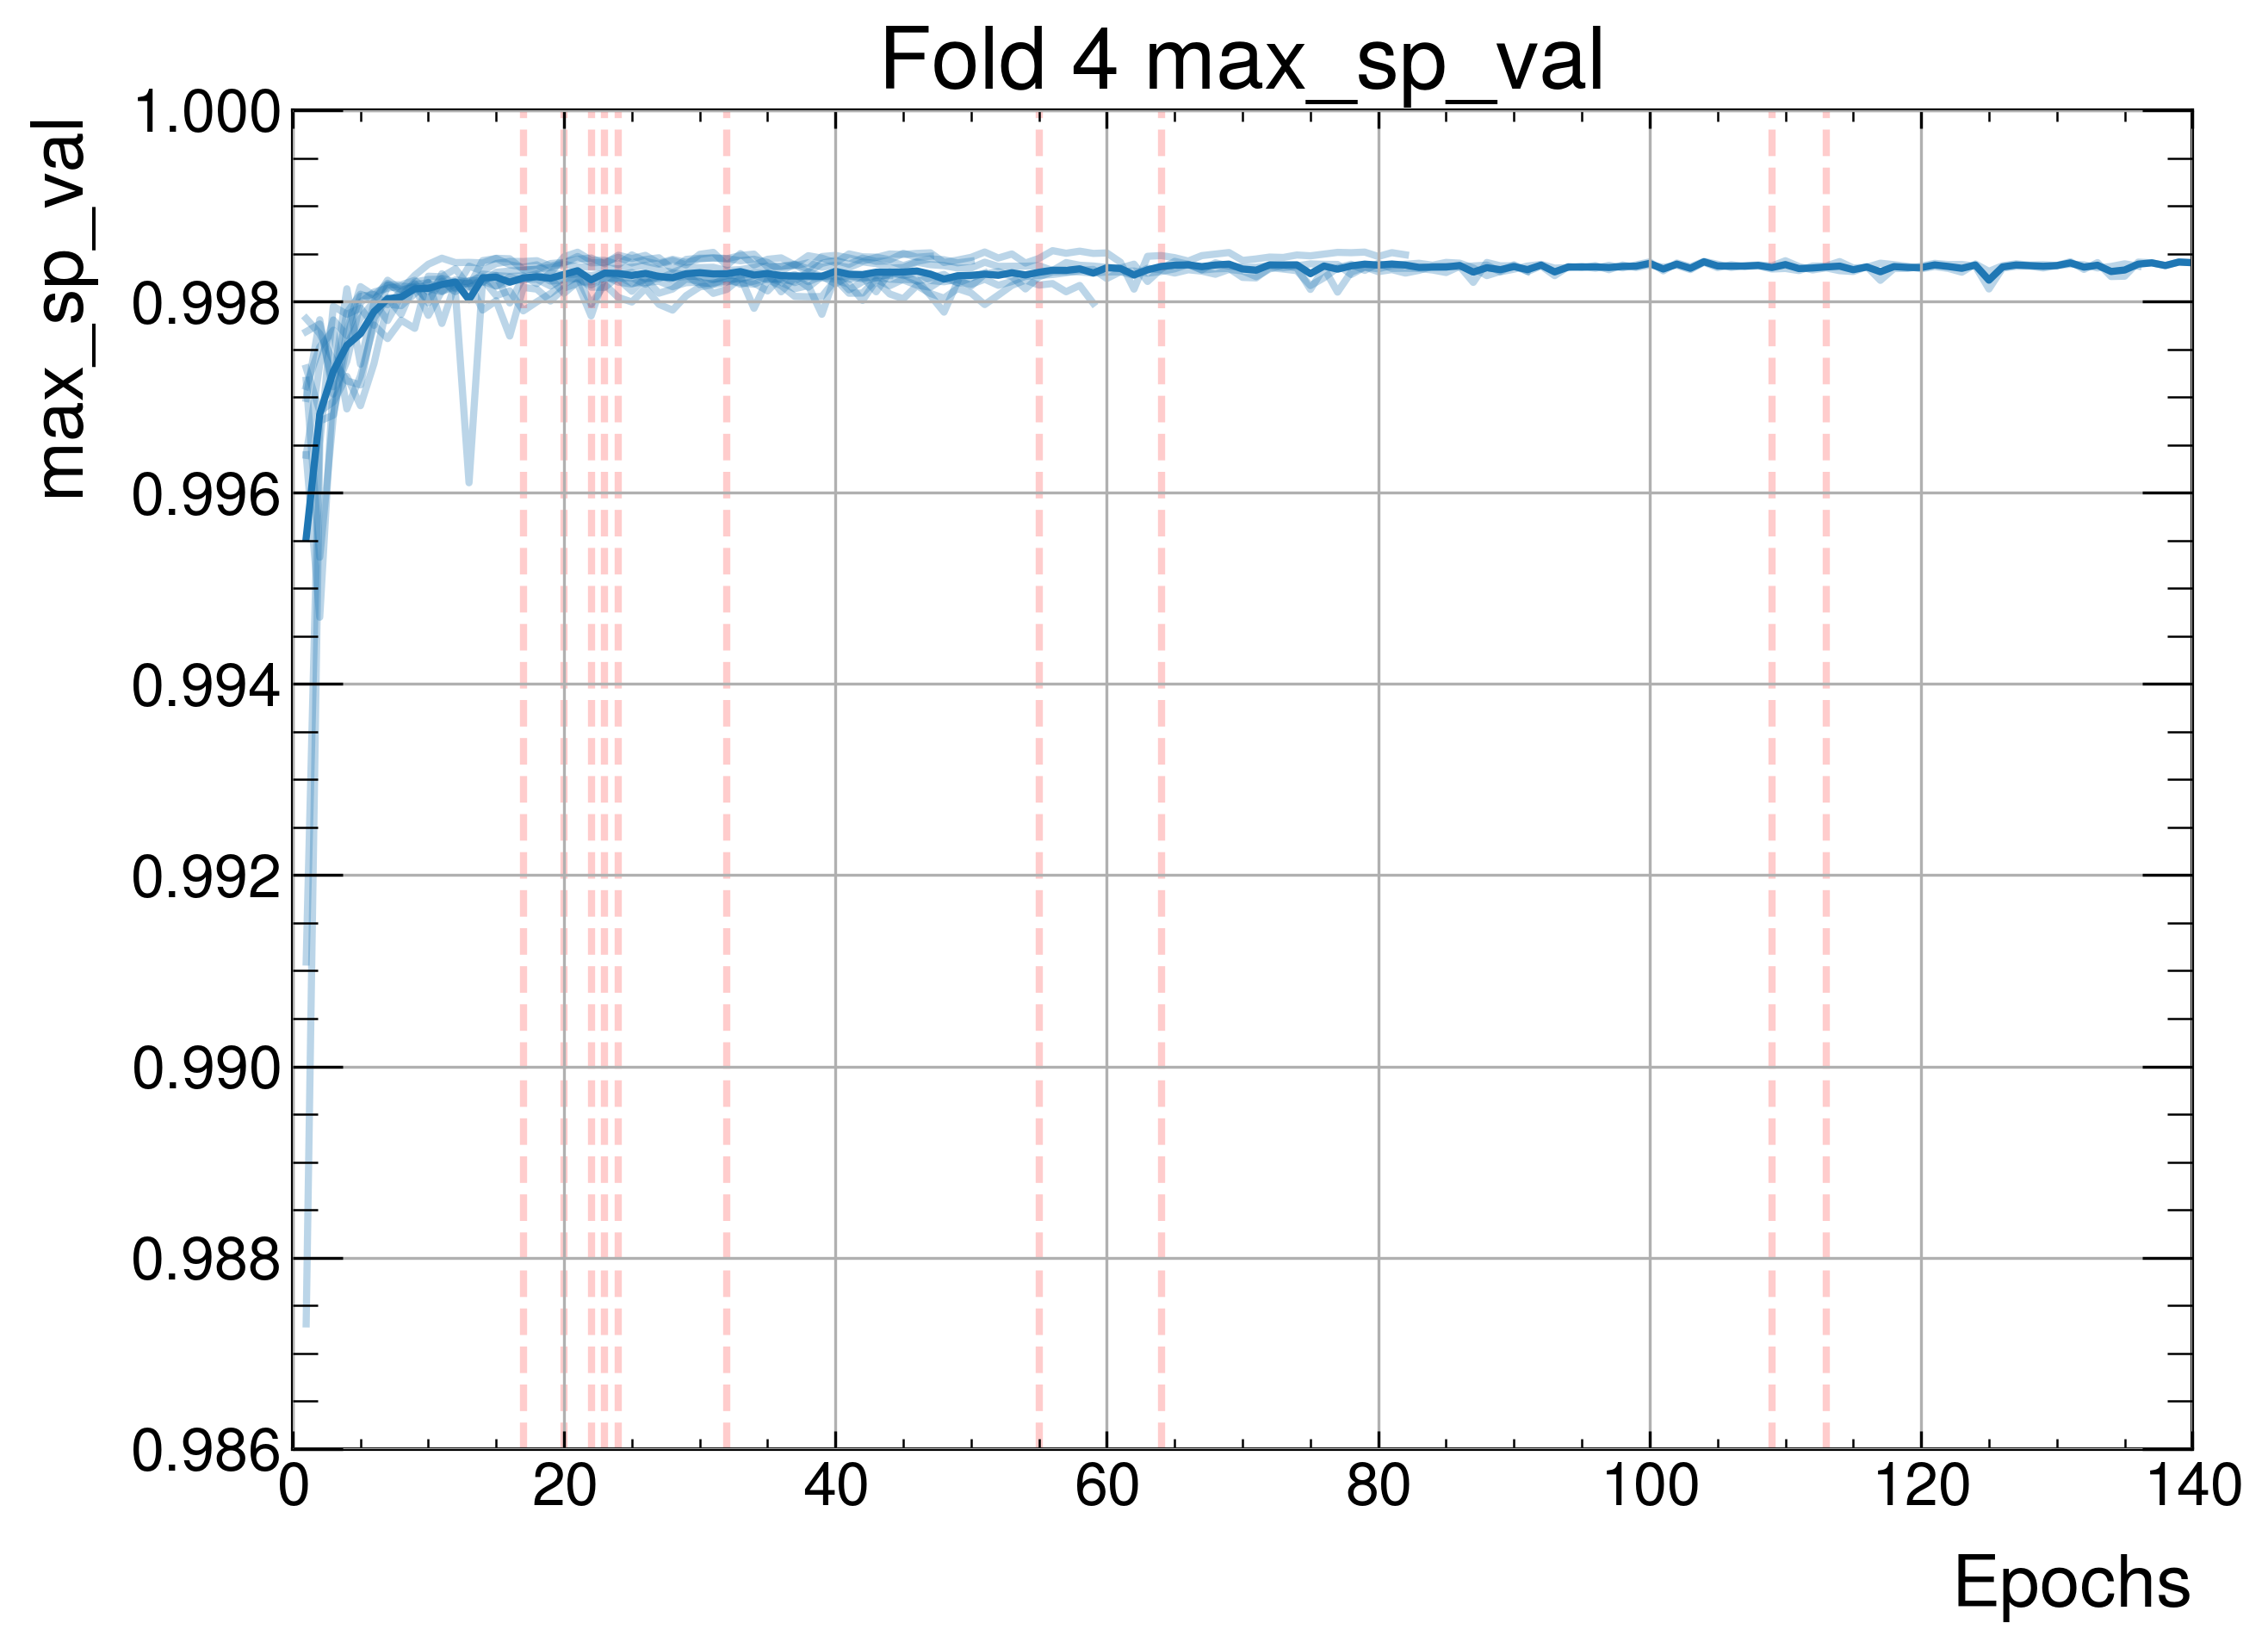

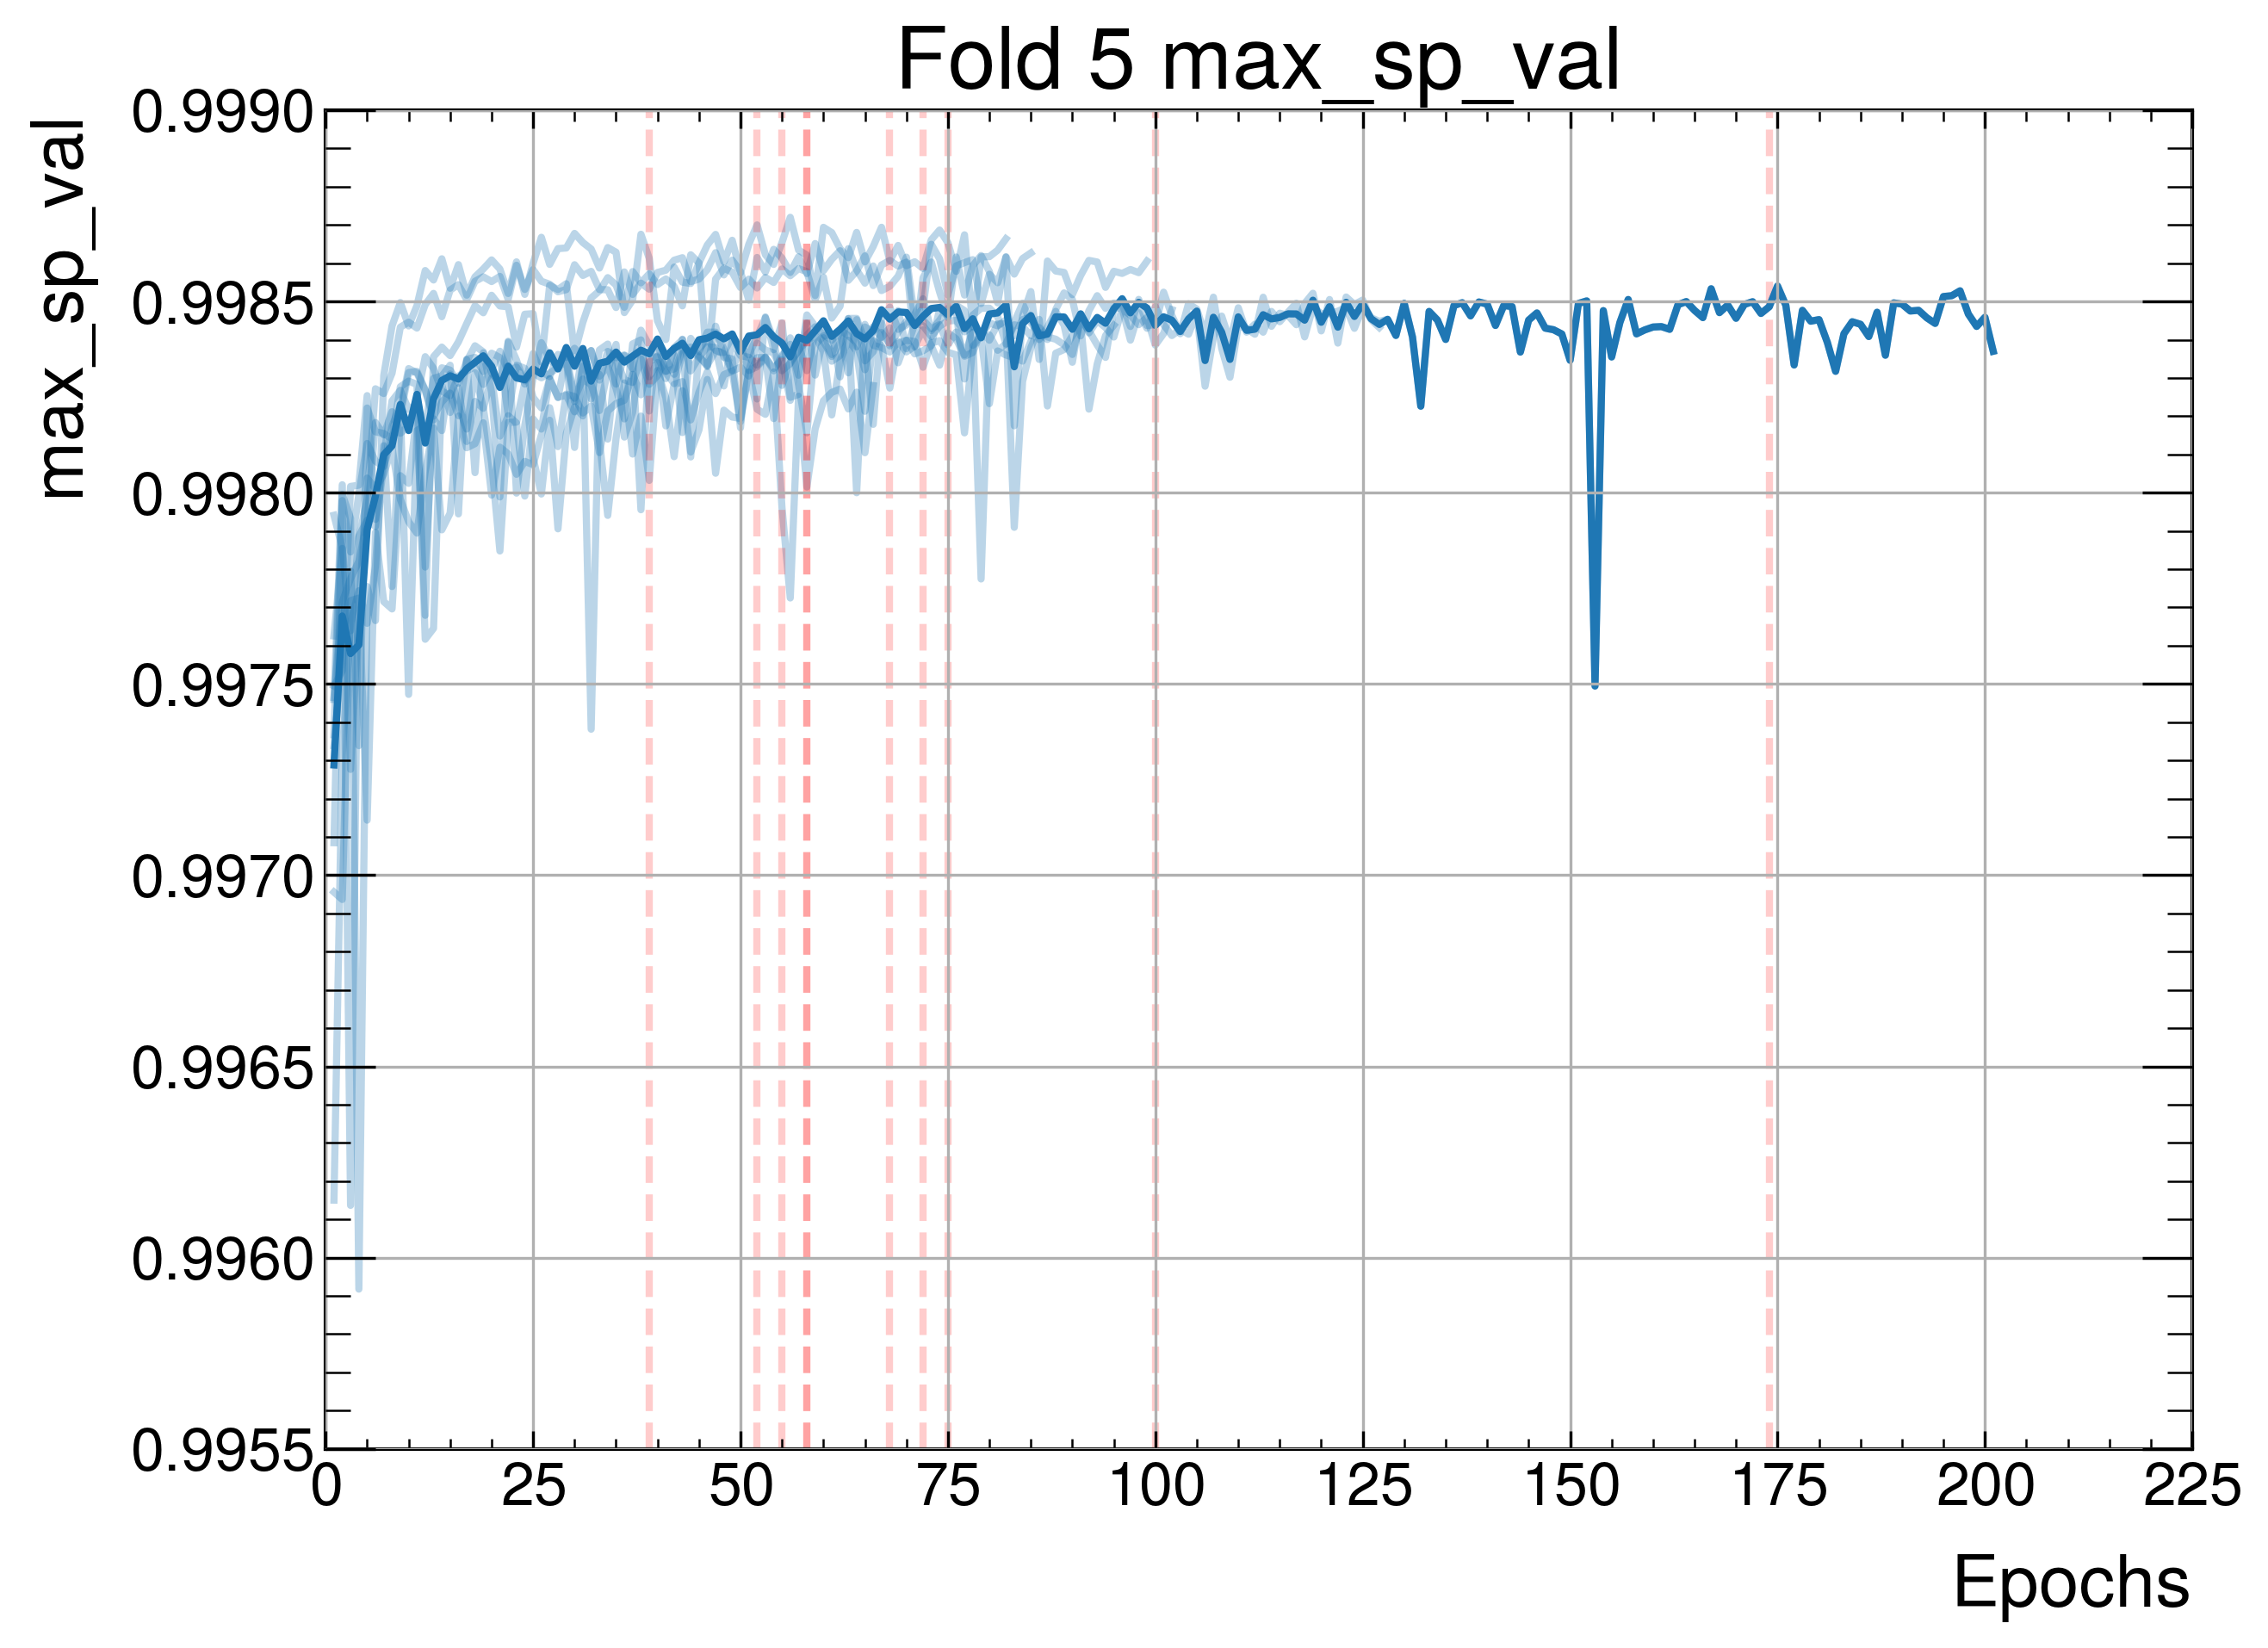

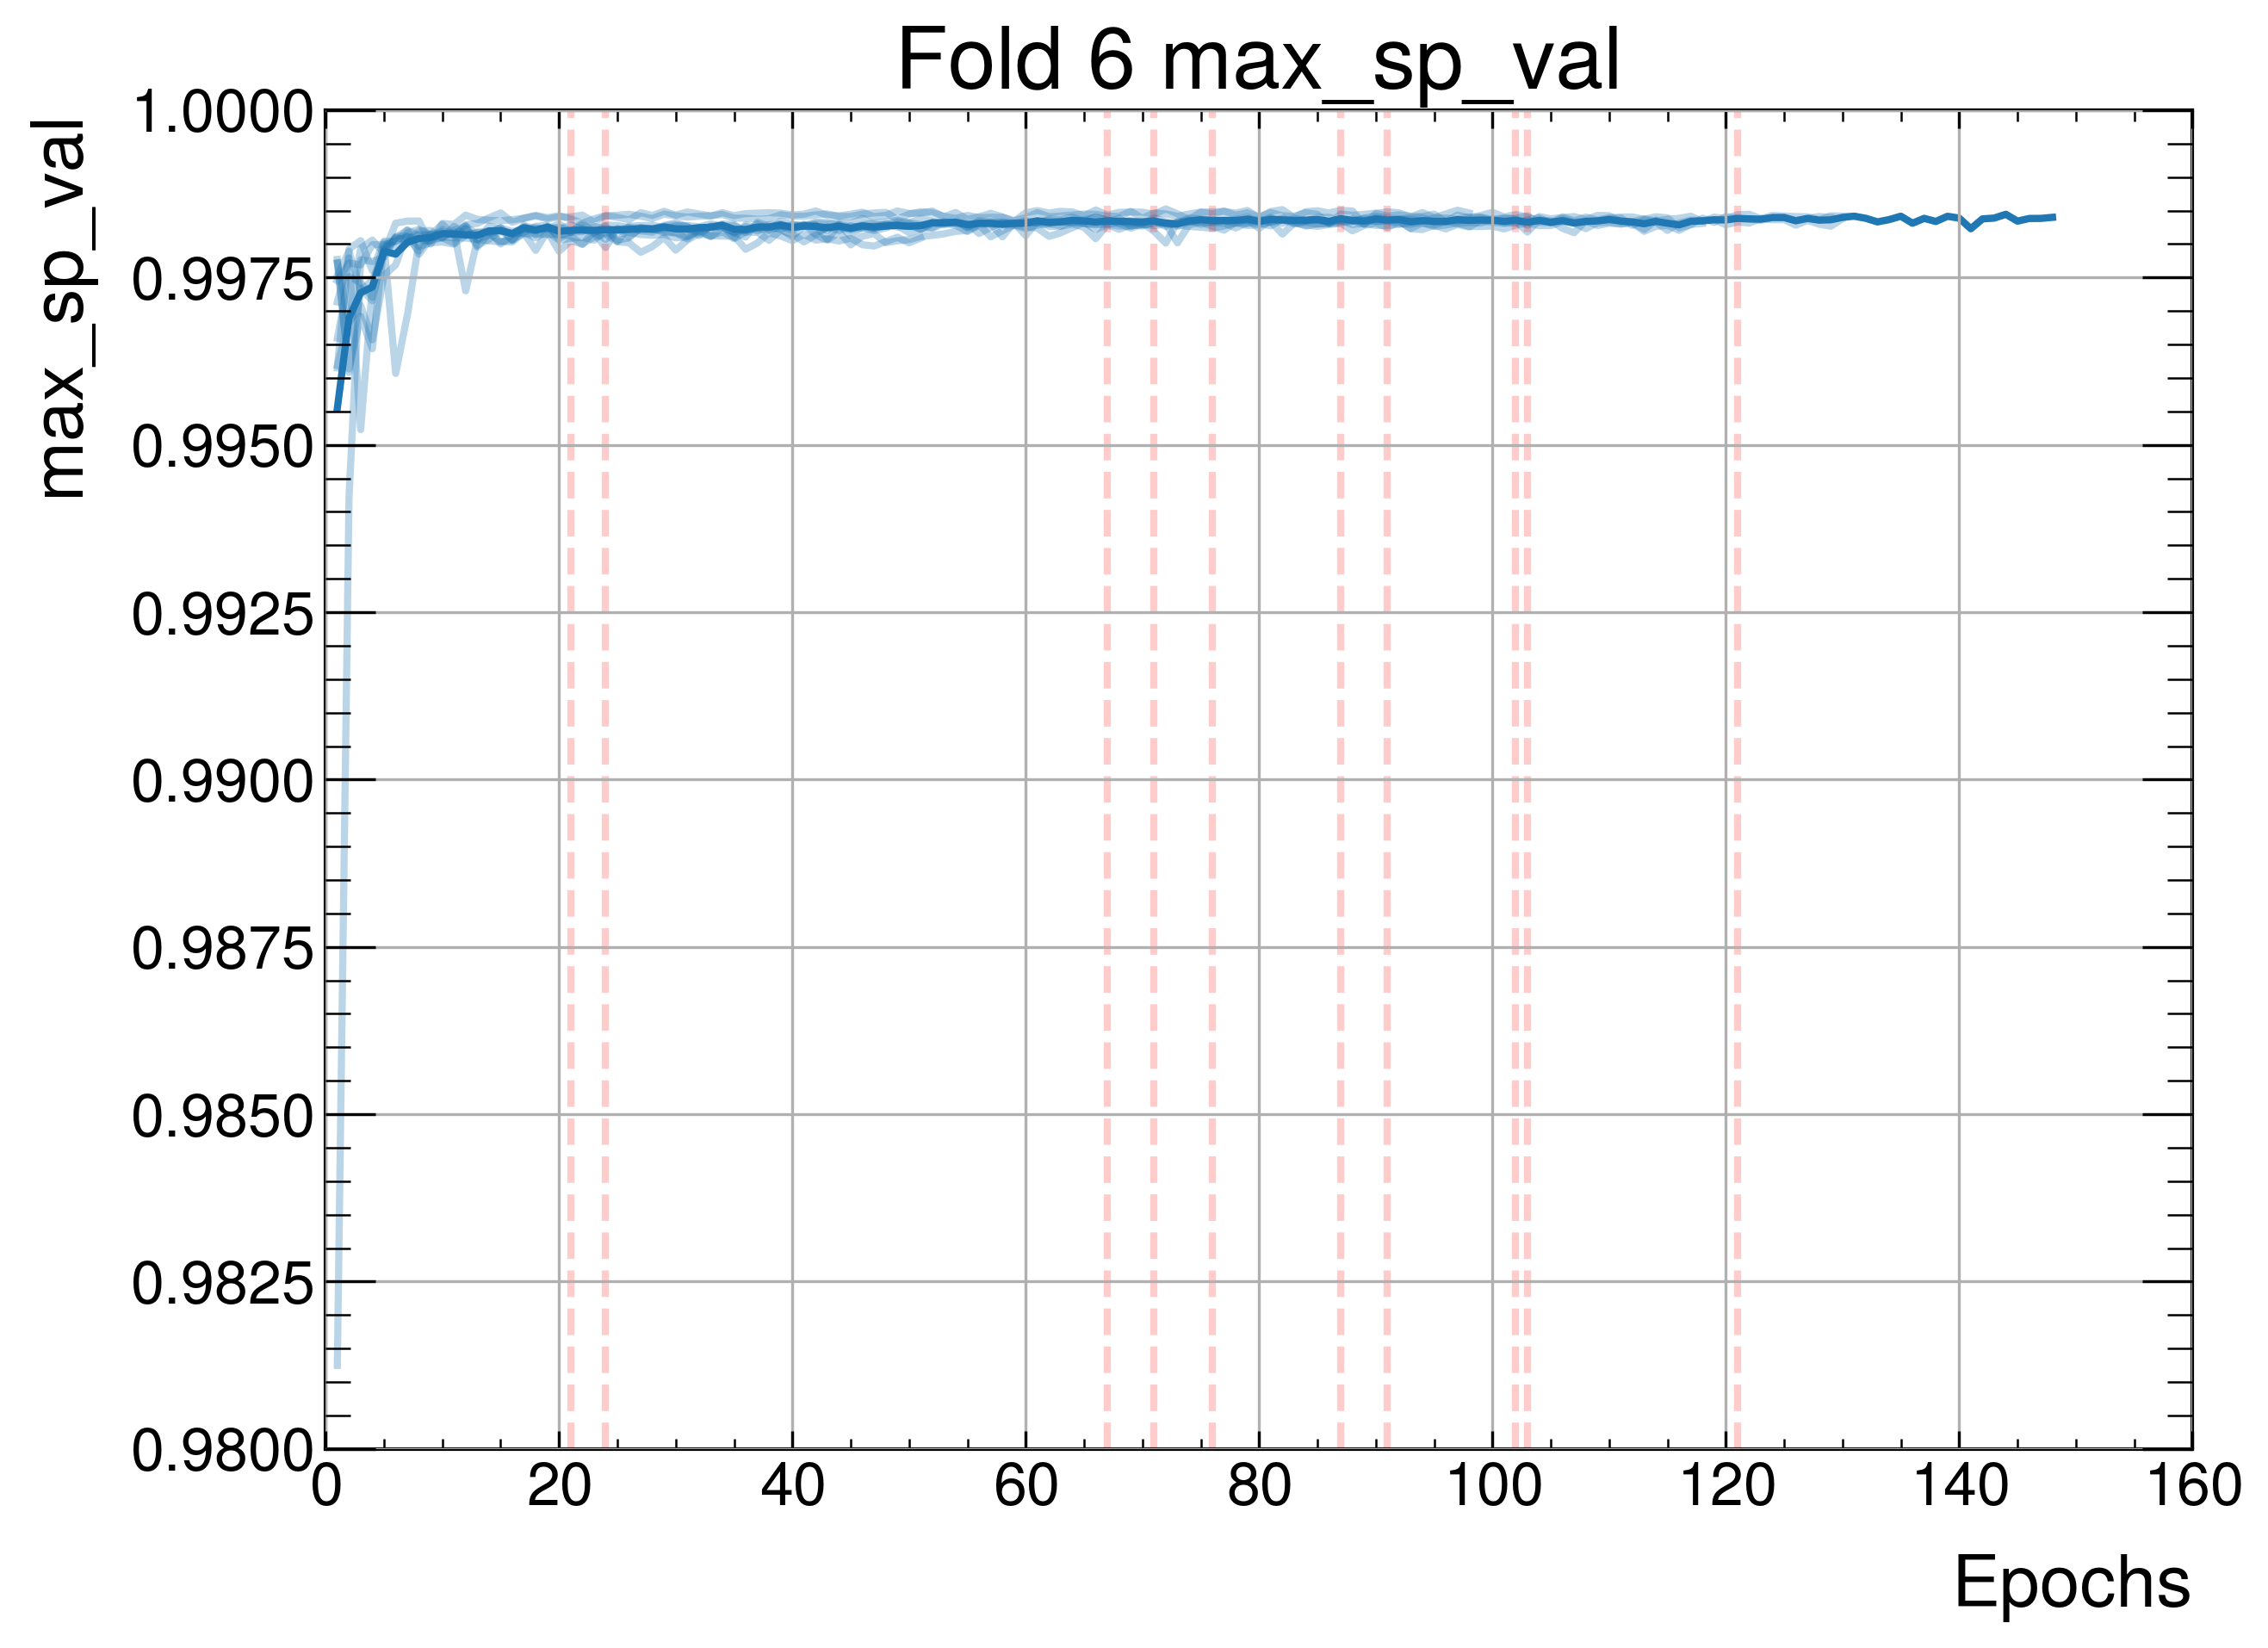

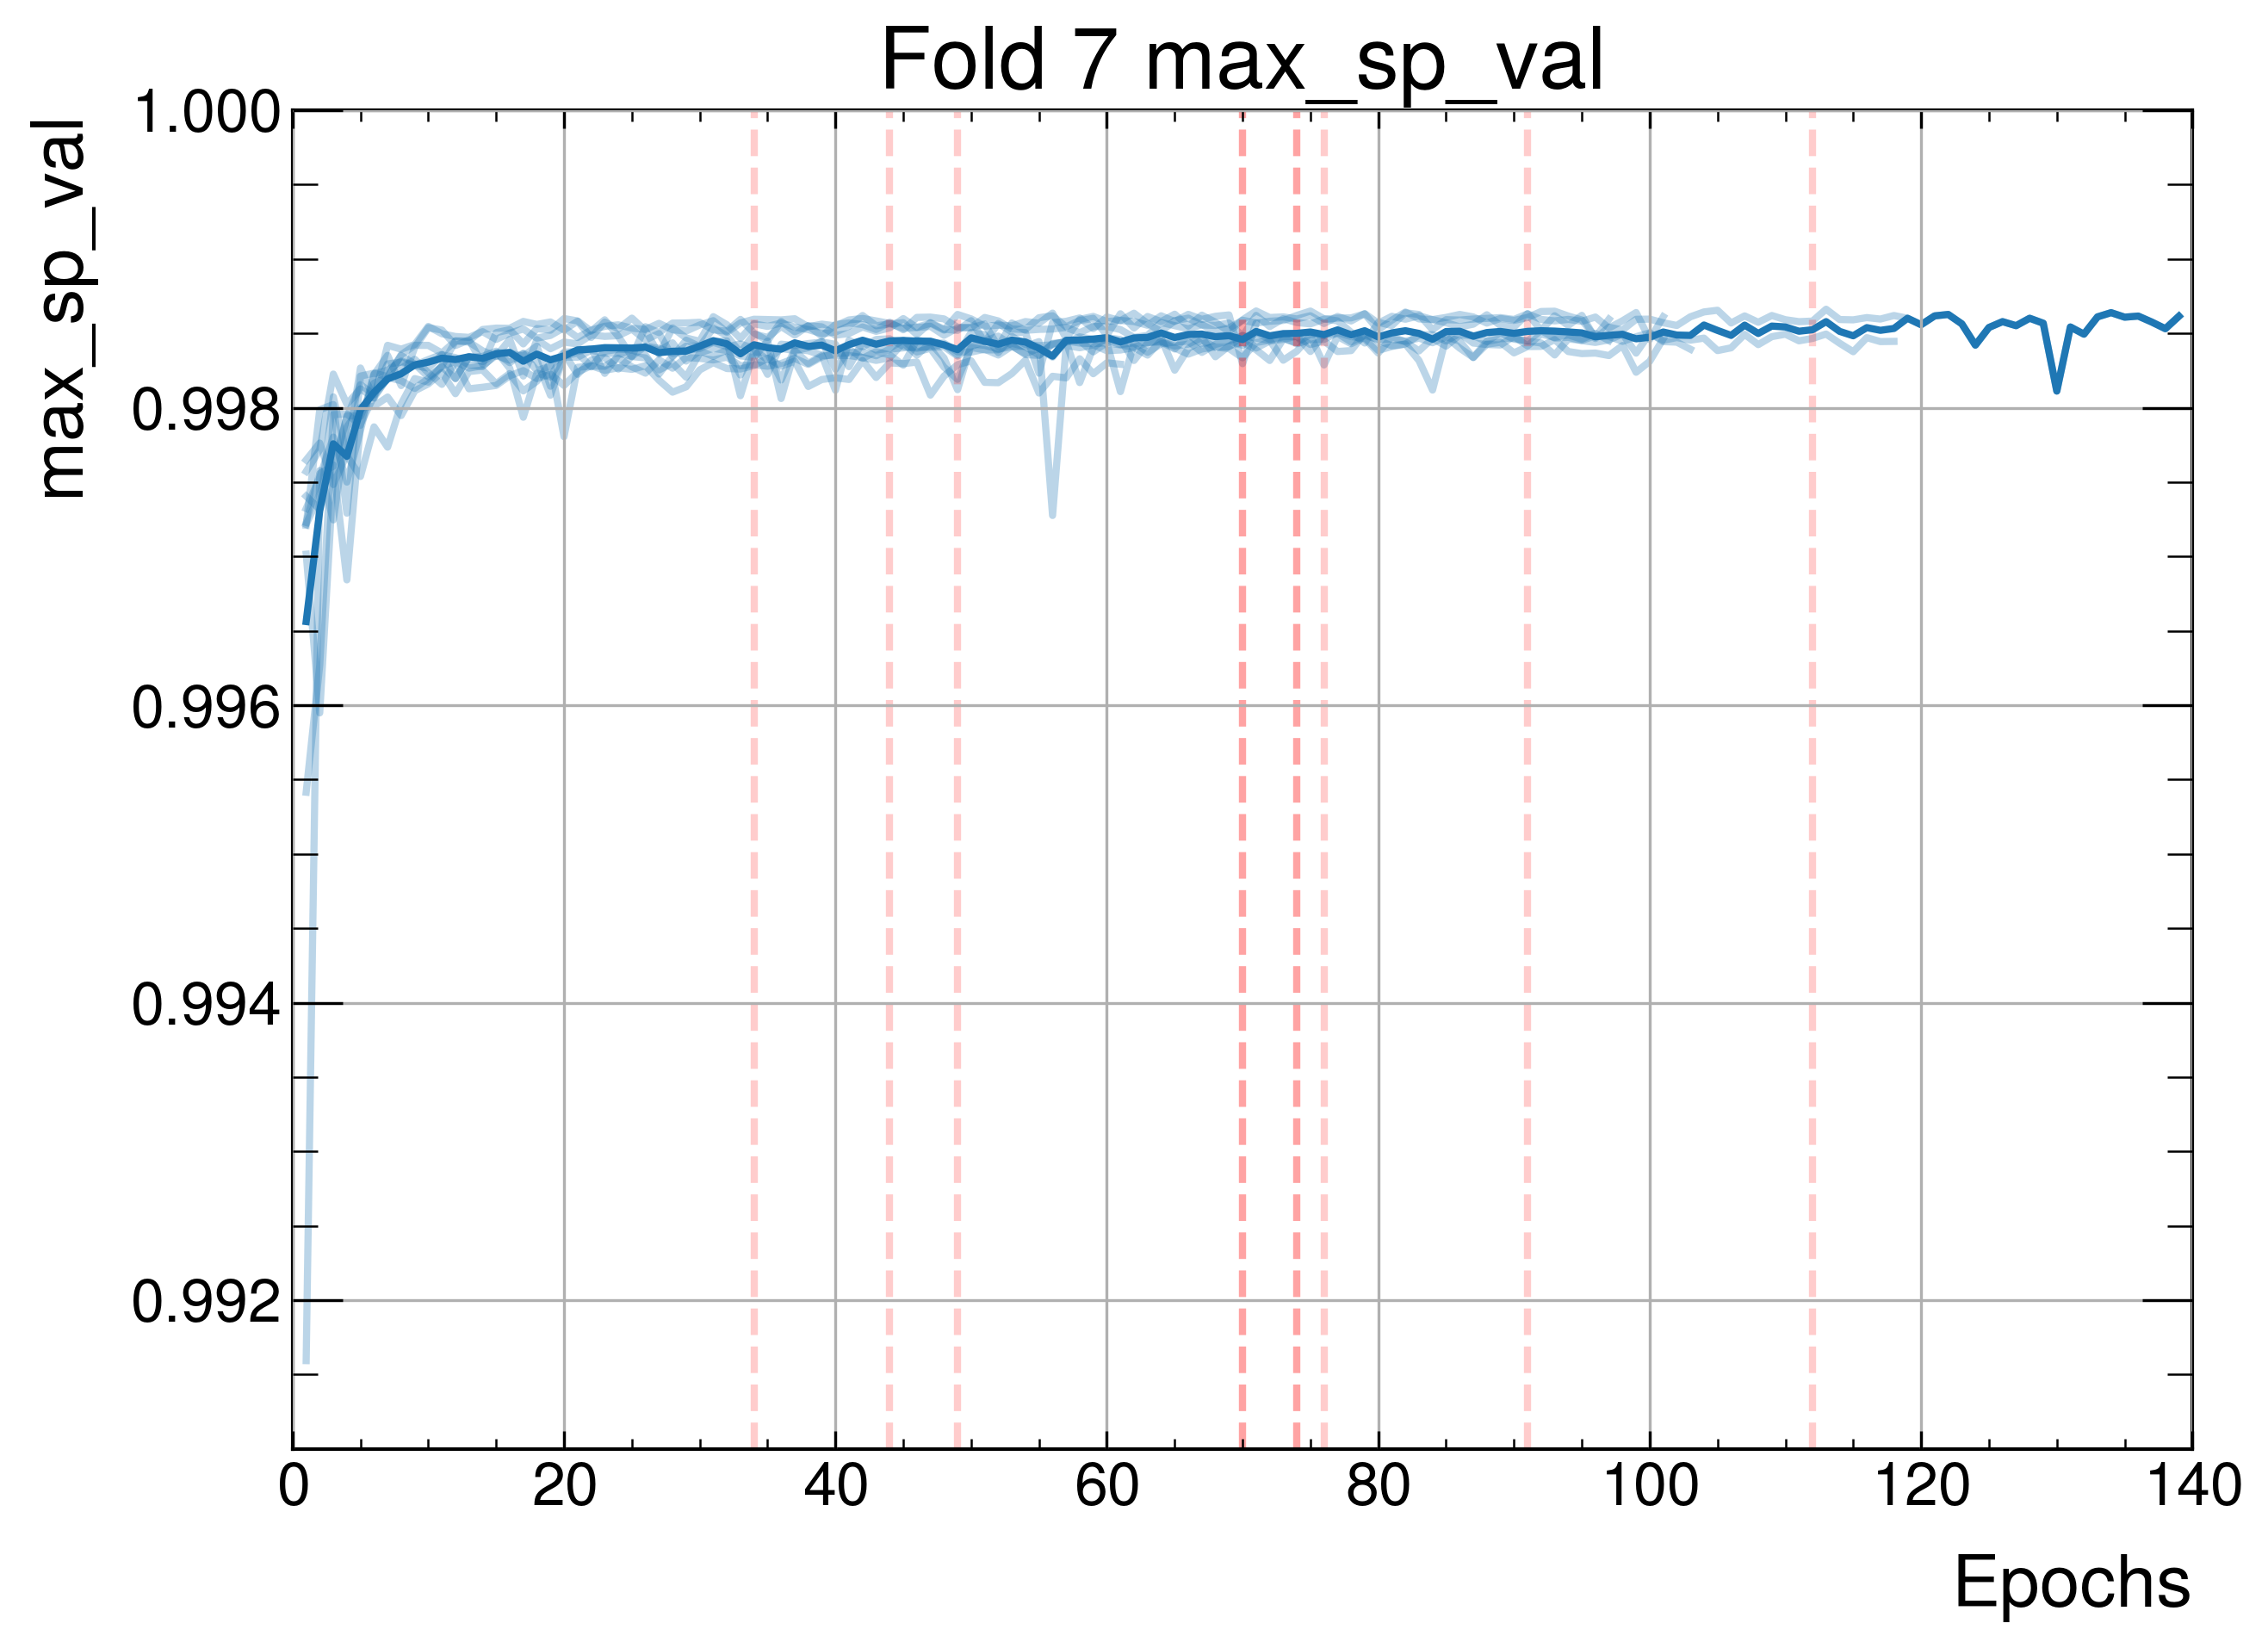

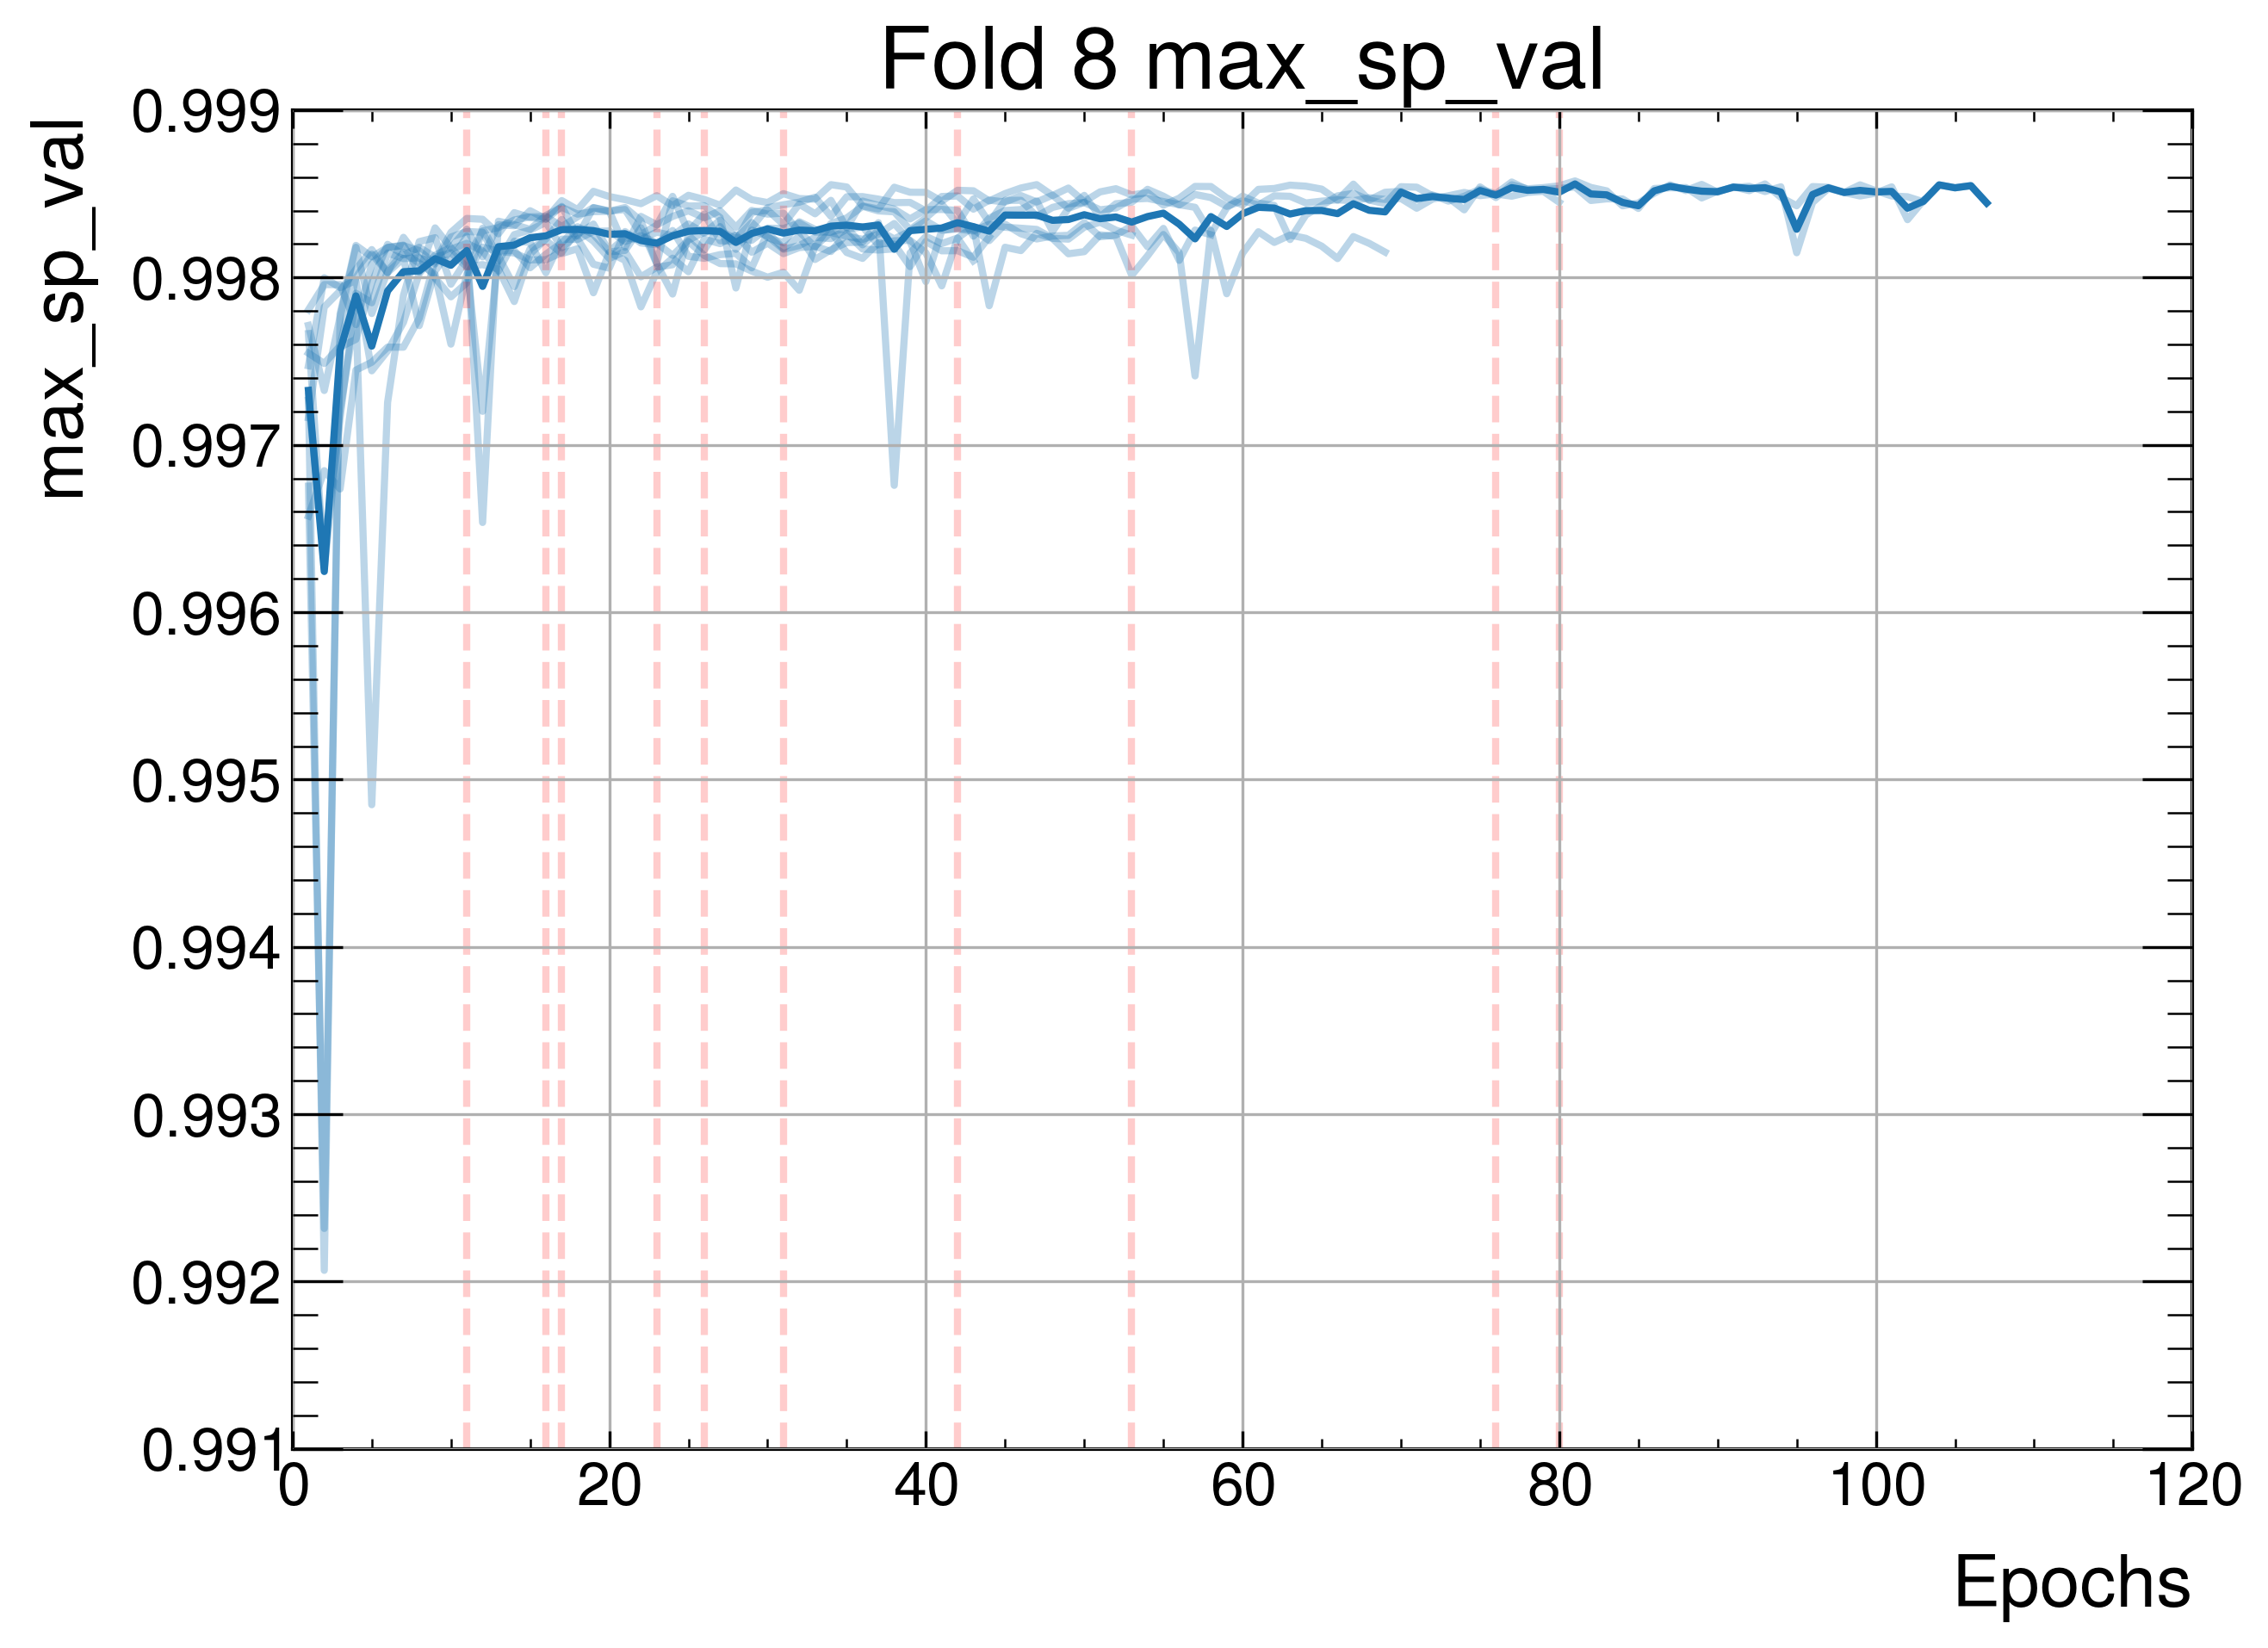

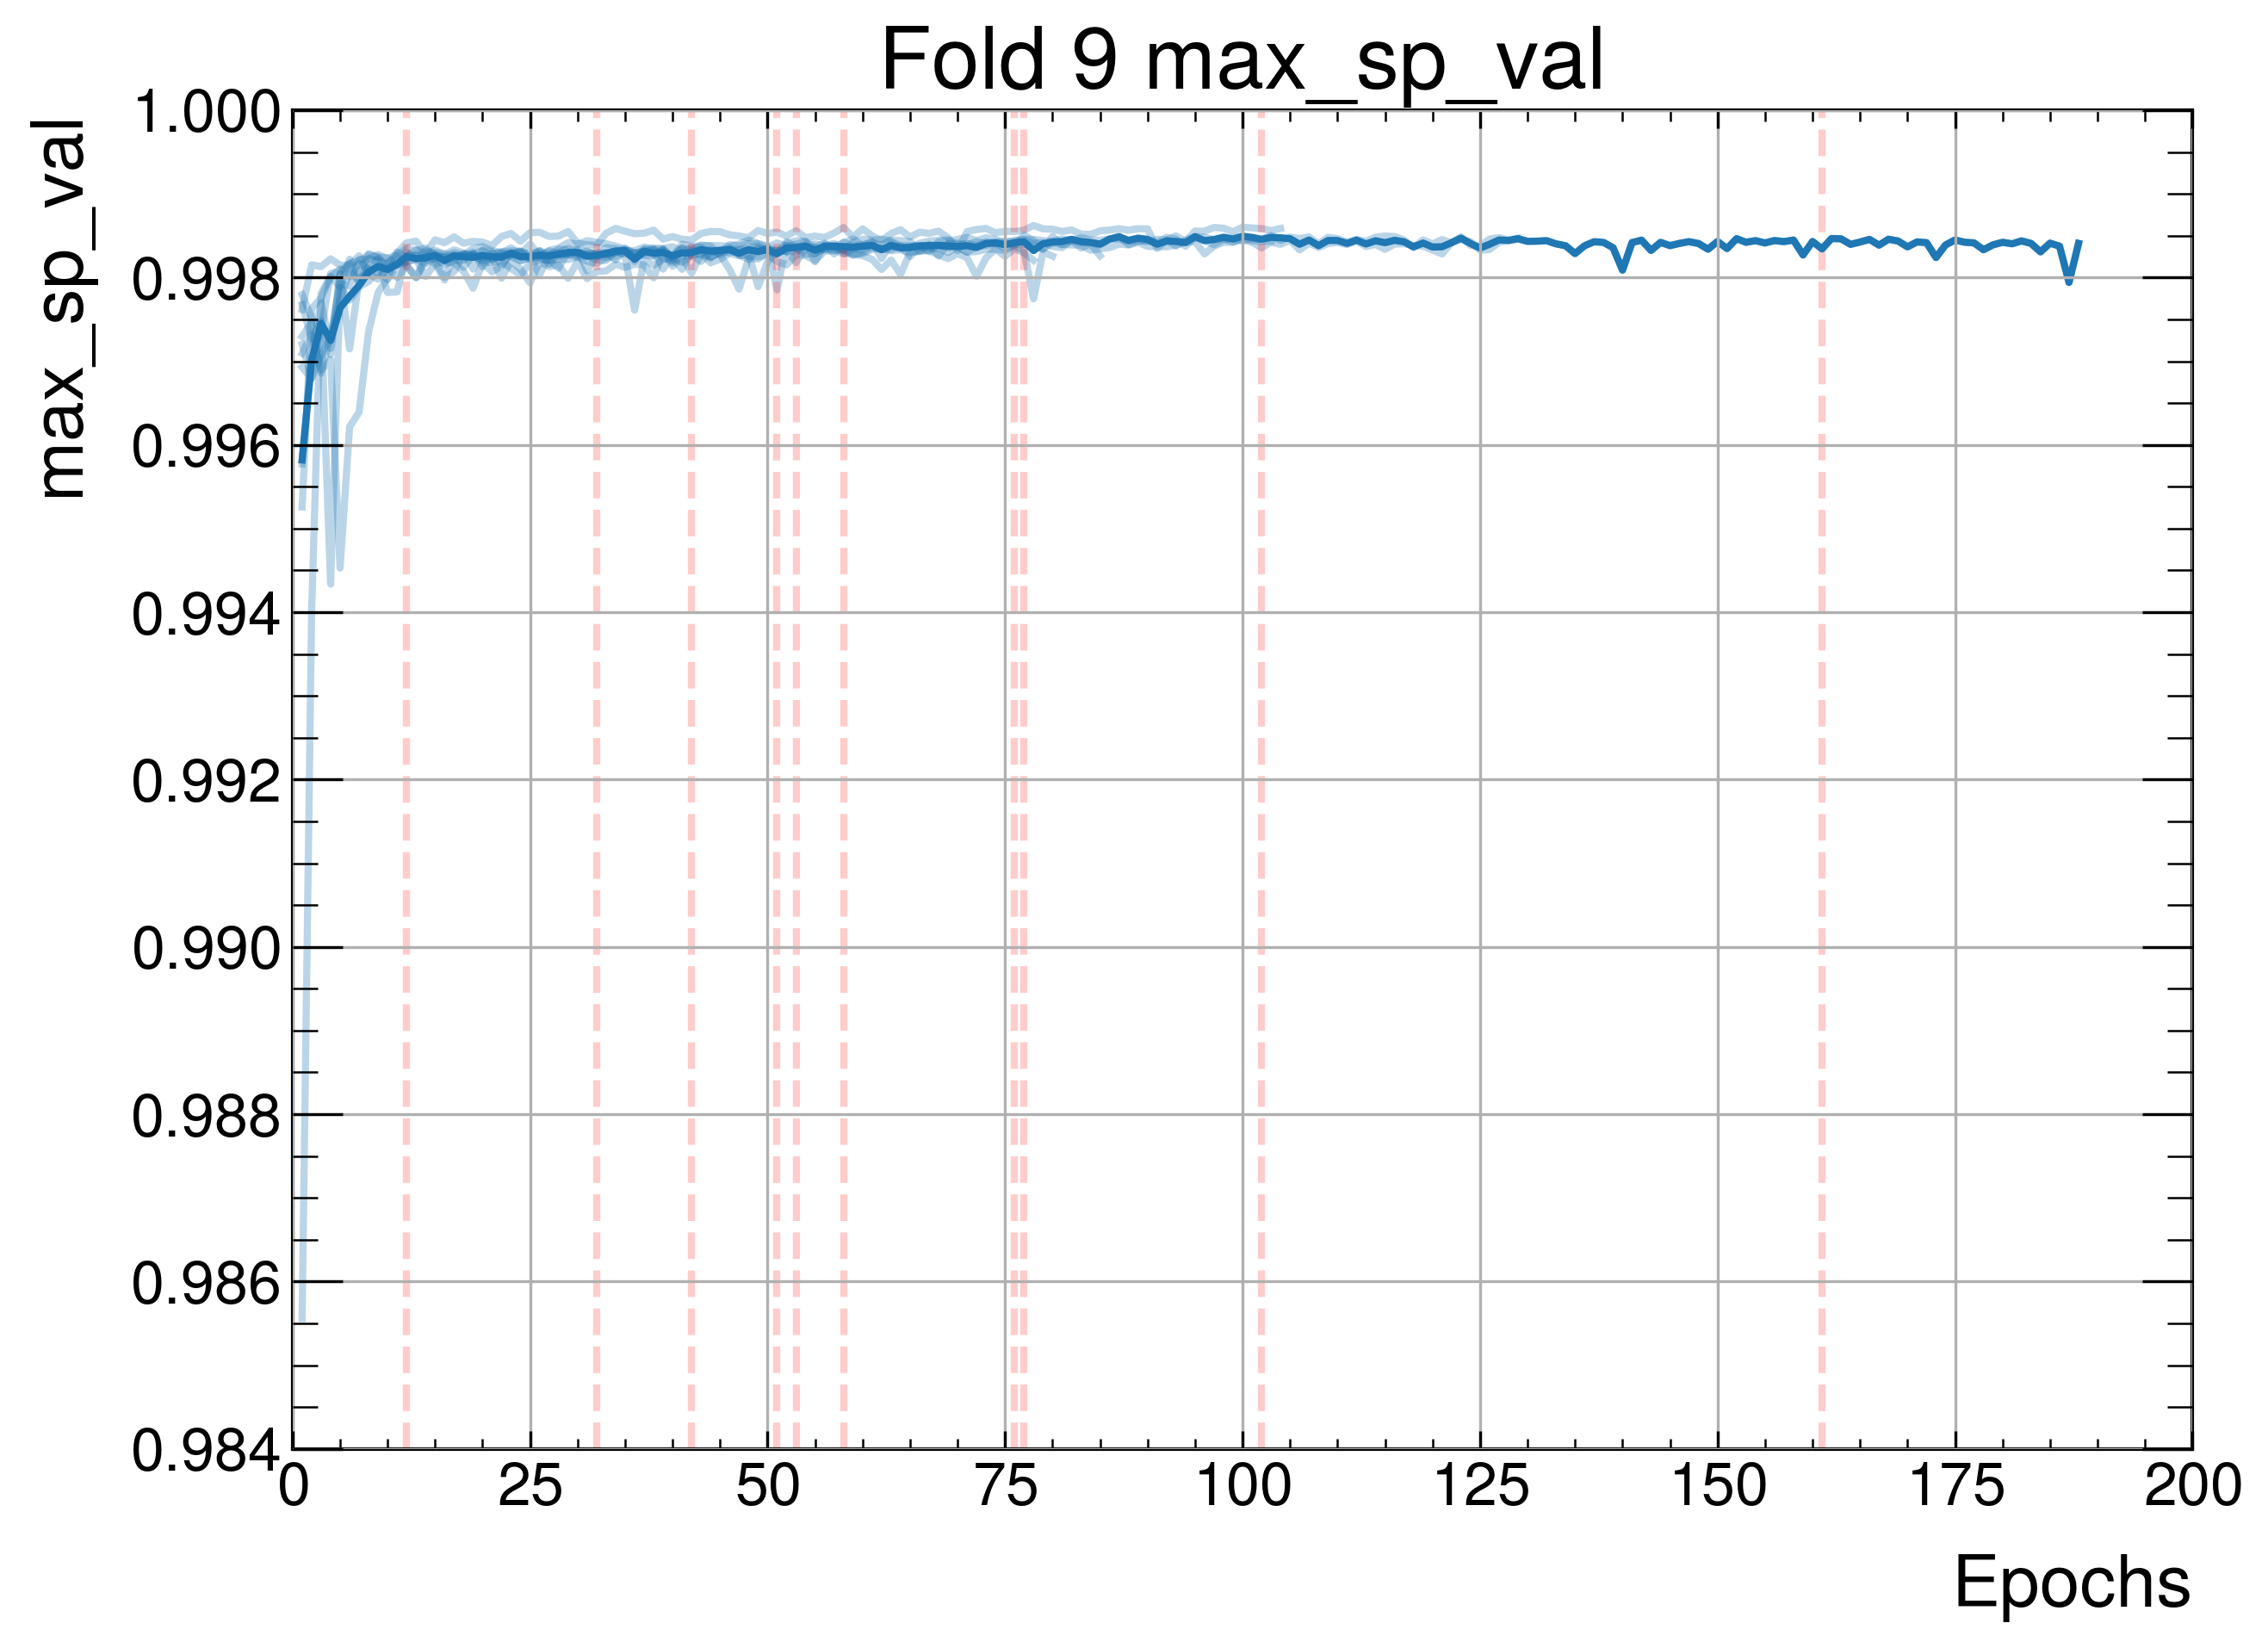

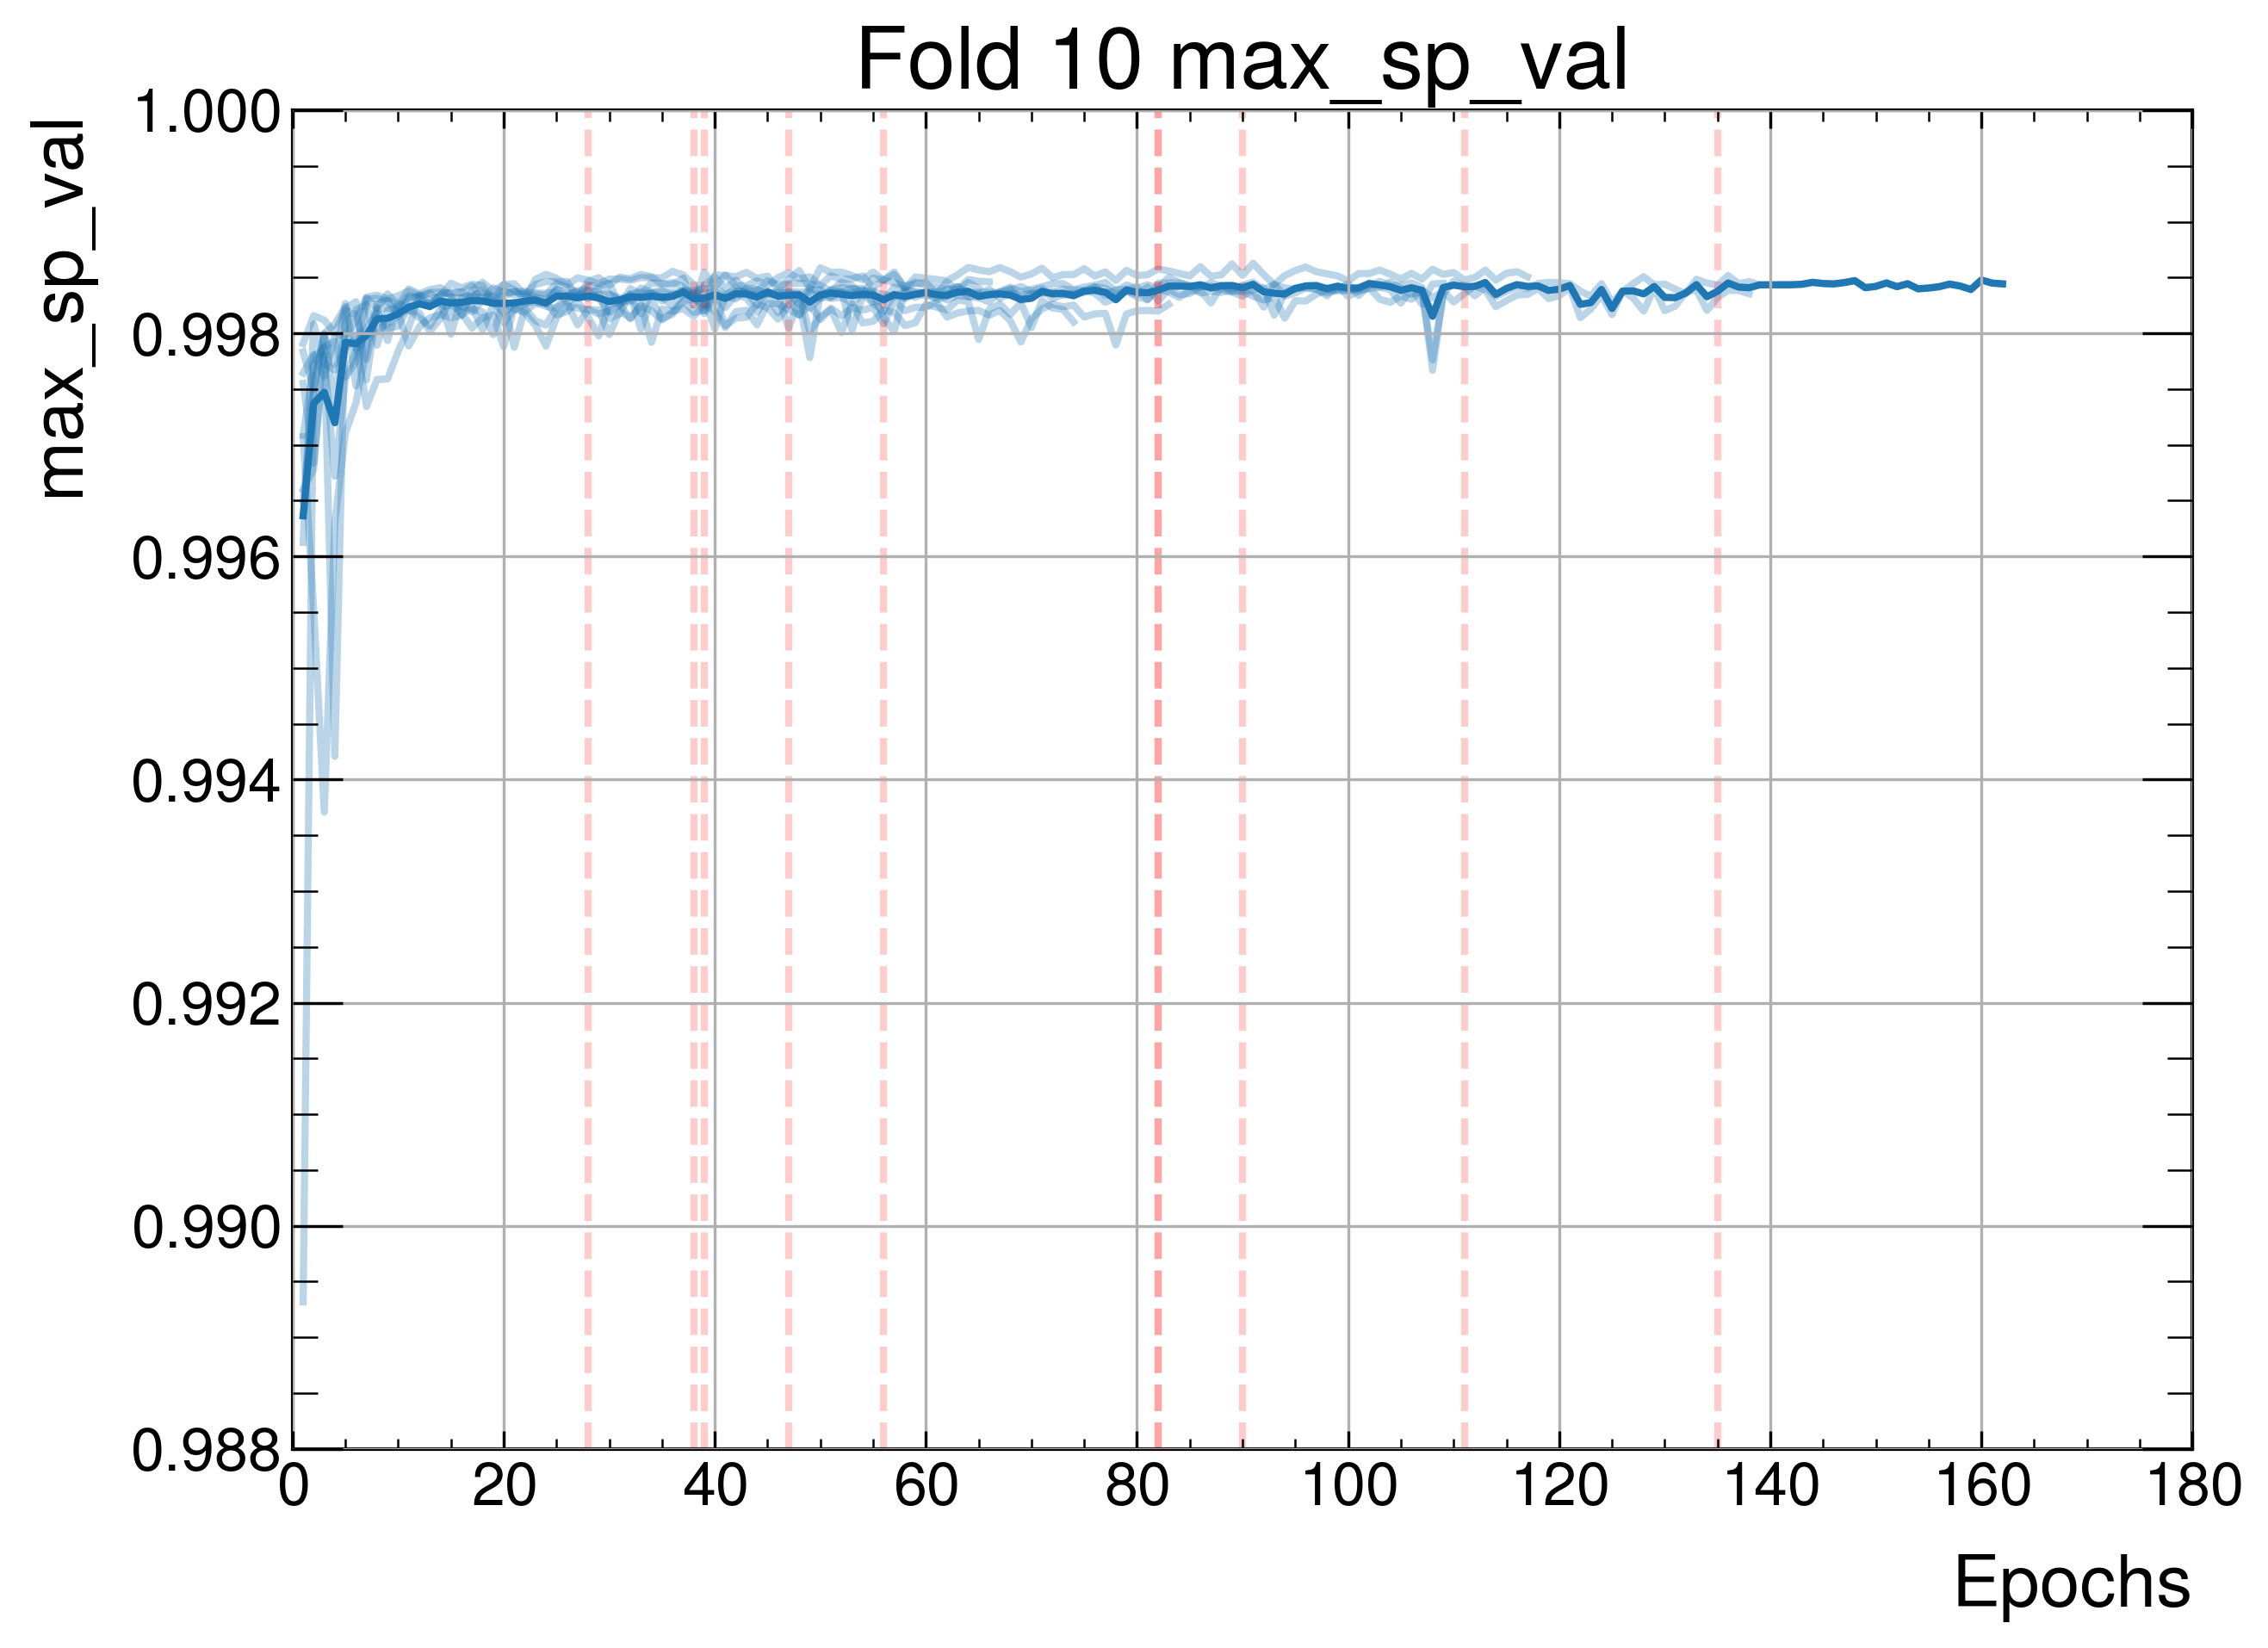

In [22]:
plots = defaultdict(dict)
metric_per_fold_dir = os.path.join(output_dir, "metrics_per_fold")
if not os.path.exists(metric_per_fold_dir):
    os.makedirs(metric_per_fold_dir)
for metric_name, metric_kwargs in metrics_to_plot.items():
    for sort in np.sort(history_df["sort"].unique()):
        print(f"Plotting {metric_name} sort {sort}")
        fig, ax = plt.subplots()
        ax.grid()
        main_ax_kwargs=metric_kwargs["main_ax"]
        plot_fold_metric(history_df,
                         metric_name=metric_name,
                         sort=sort, ax=ax,
                         **main_ax_kwargs["plot_kwargs"])
        ax.set(title=f"Fold {sort+1} {metric_name}",
               ylabel=metric_name, xlabel="Epochs",
               **main_ax_kwargs["set_kwargs"])
        if main_ax_kwargs["legend_kwargs"] is not None:
            ax.legend(**main_ax_kwargs["legend_kwargs"])
        
        sub_ax_kwargs=metric_kwargs["sub_ax"]
        if sub_ax_kwargs:
            sub_ax = fig.add_axes(**sub_ax_kwargs["add_axes_kwargs"])
            sub_ax.grid()
            plot_fold_metric(history_df,
                 metric_name=metric_name,
                 sort=sort, ax=sub_ax,
                 **sub_ax_kwargs["plot_kwargs"])
            sub_ax.set(**sub_ax_kwargs["set_kwargs"])
        plots[metric_name][sort] = (fig, ax)
        fig.tight_layout()
        fig.savefig(os.path.join(metric_per_fold_dir, f"{metric_name}_fold_{sort+1}.png"))

## Deep Dive

In [23]:
metric_df = get_metric_df_from_history_df(history_df,
                                          metric_name="max_sp_val",
                                          sort=0)
metric_df["mean"] = metric_df.mean(axis=1)
metric_df["std"] = metric_df.std(axis=1)
metric_df

,init 0,init 1,init 2,init 3,init 4,init 5,init 6,init 7,init 8,init 9,mean,std
0,0.995660,0.994924,0.997170,0.997107,0.997117,0.993368,0.997786,0.034826,0.996839,0.997533,0.900233,0.288472
1,0.995851,0.997640,0.997339,0.997661,0.997559,0.996957,0.997919,0.034826,0.996874,0.997542,0.901017,0.288731
2,0.997207,0.997564,0.997055,0.997729,0.997282,0.997762,0.997244,0.034826,0.992651,0.997633,0.900695,0.288627
3,0.997544,0.997716,0.996199,0.997362,0.996782,0.998055,0.996456,0.034826,0.997361,0.997587,0.900989,0.288721
4,0.997013,0.997937,0.997814,0.997077,0.997780,0.998023,0.995782,0.034826,0.996657,0.997661,0.901057,0.288744
...,...,...,...,...,...,...,...,...,...,...,...,...
258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998308,NaN,0.998308,0.000000
259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998388,NaN,0.998388,0.000000
260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998407,NaN,0.998407,0.000000
261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998388,NaN,0.998388,0.000000


In [20]:
metric_df = get_metric_df_from_history_df(history_df,
                                          metric_name="val_accureacy",
                                          sort=0)
metric_df["mean"] = metric_df.mean(axis=1)
metric_df["std"] = metric_df.std(axis=1)
metric_df

,init 0,init 1,init 2,init 3,init 4,init 5,init 6,init 7,init 8,init 9,mean,std
0,0.990997,0.977624,0.995296,0.992983,0.993909,0.986586,0.992871,0.686247,0.989533,0.975535,0.958158,0.090864
1,0.995249,0.997132,0.996204,0.996362,0.996427,0.994120,0.996583,0.689252,0.996262,0.997038,0.965463,0.092074
2,0.995927,0.997388,0.996072,0.996643,0.996482,0.997443,0.996750,0.689253,0.995546,0.997135,0.965864,0.092206
3,0.996636,0.997574,0.996452,0.996510,0.996488,0.997478,0.996635,0.689253,0.996467,0.997304,0.966080,0.092276
4,0.996751,0.997687,0.997578,0.996741,0.997143,0.997653,0.996657,0.689253,0.995672,0.997435,0.966257,0.092336
...,...,...,...,...,...,...,...,...,...,...,...,...
258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998316,NaN,0.998316,0.000000
259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998317,NaN,0.998317,0.000000
260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998333,NaN,0.998333,0.000000
261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998336,NaN,0.998336,0.000000


In [16]:
metric_df.loc[0].describe()

count    12.000000
mean      0.885884
std       0.264932
min       0.090864
25%       0.971191
50%       0.988060
75%       0.992899
max       0.995296
Name: 0, dtype: float64

## Finish

In [12]:
plt.close("all")